In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Синтезируем временные ряды 5-минутки для каждого из 2215 домов района Люблино

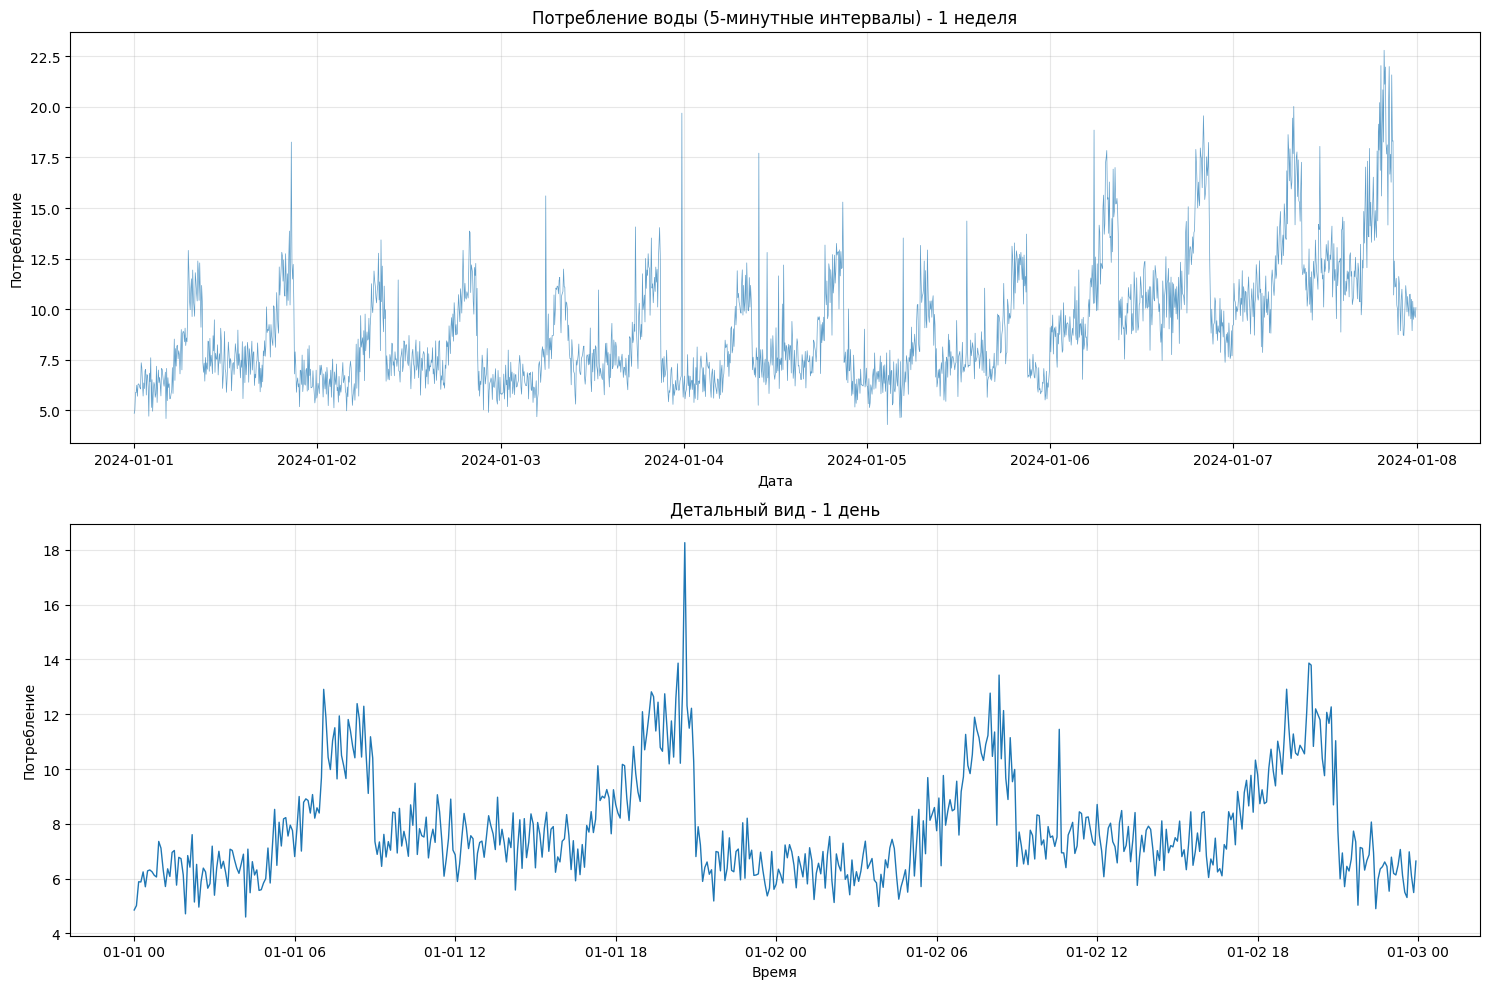

Статистика данных:
Всего точек: 2016
Период: 2024-01-01 00:00:00 - 2024-01-07 23:55:00
Среднее потребление: 9.06
Максимальное потребление: 22.80
Минимальное потребление: 4.30


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_water_usage_5min(days=30, noise_level=0.1, base_consumption=5):
    """
    Генерация временного ряда потребления воды с 5-минутным интервалом
    с суточной и недельной сезонностью
    """
    # Параметры
    minutes_per_hour = 12  # 5 минутные интервалы (60/5 = 12)
    hours_per_day = 24
    days_per_week = 7
    total_intervals = days * hours_per_day * minutes_per_hour

    # Создание временного индекса
    date_range = pd.date_range(start='2024-01-01', periods=total_intervals, freq='5min')

    # Детальный суточный паттерн (5-минутные интервалы)
    # Более плавные переходы между пиками
    time_slots = np.linspace(0, 24, minutes_per_hour * hours_per_day)
    hourly_pattern = np.zeros_like(time_slots)

    # Заполнение паттерна потребления
    for i, hour in enumerate(time_slots):
        if 0 <= hour < 5:    # Ночь
            hourly_pattern[i] = 1 + 0.5 * np.sin(hour * np.pi/5)
        elif 5 <= hour < 7:  # Раннее утро, рост
            hourly_pattern[i] = 2 + 2 * ((hour - 5)/2)
        elif 7 <= hour < 9:  # Утренний пик (6-8 утра)
            hourly_pattern[i] = 6 - 0.5 * abs(hour - 7.5)
        elif 9 <= hour < 17: # День
            hourly_pattern[i] = 2 + 0.5 * np.sin((hour - 9) * np.pi/8)
        elif 17 <= hour < 19: # Вечер, рост
            hourly_pattern[i] = 3 + 2 * ((hour - 17)/2)
        elif 19 <= hour < 21: # Вечерний пик
            hourly_pattern[i] = 7 - 0.5 * abs(hour - 20)
        else:                # Поздний вечер/ночь
            hourly_pattern[i] = 2 - 1 * ((hour - 21)/3)

    # Недельная сезонность
    daily_multiplier = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.6])  # выходные выше

    # Генерация ряда
    ts = []
    for i, timestamp in enumerate(date_range):
        # Индекс в суточном паттерне
        total_minutes = timestamp.hour * 60 + timestamp.minute
        pattern_idx = int(total_minutes / 5)

        day_of_week = timestamp.dayofweek

        # Базовое значение + суточный паттерн
        value = base_consumption + hourly_pattern[pattern_idx % len(hourly_pattern)]

        # Умножение на недельный коэффициент
        value *= daily_multiplier[day_of_week]

        # Добавление случайных всплесков (кратковременное увеличение потребления)
        if np.random.random() < 0.02:  # 2% chance of spike
            value += np.random.exponential(3)

        # Добавление шума
        noise = np.random.normal(0, noise_level * value)
        value += noise

        ts.append(max(0.1, value))  # избегаем отрицательных значений

    return pd.Series(ts, index=date_range, name='water_consumption')

# Генерация данных
water_ts_5min = generate_water_usage_5min(days=7)  # 1 неделя для наглядности

# Визуализация
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Полная неделя
ax1.plot(water_ts_5min.index, water_ts_5min.values, linewidth=0.5, alpha=0.7)
ax1.set_title('Потребление воды (5-минутные интервалы) - 1 неделя')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Потребление')
ax1.grid(True, alpha=0.3)

# Один день для деталей
one_day = water_ts_5min['2024-01-01':'2024-01-02']
ax2.plot(one_day.index, one_day.values, linewidth=1)
ax2.set_title('Детальный вид - 1 день')
ax2.set_xlabel('Время')
ax2.set_ylabel('Потребление')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print("Статистика данных:")
print(f"Всего точек: {len(water_ts_5min)}")
print(f"Период: {water_ts_5min.index[0]} - {water_ts_5min.index[-1]}")
print(f"Среднее потребление: {water_ts_5min.mean():.2f}")
print(f"Максимальное потребление: {water_ts_5min.max():.2f}")
print(f"Минимальное потребление: {water_ts_5min.min():.2f}")

Выброс не нравится, уберу, но как идею для аномалии можно использовать

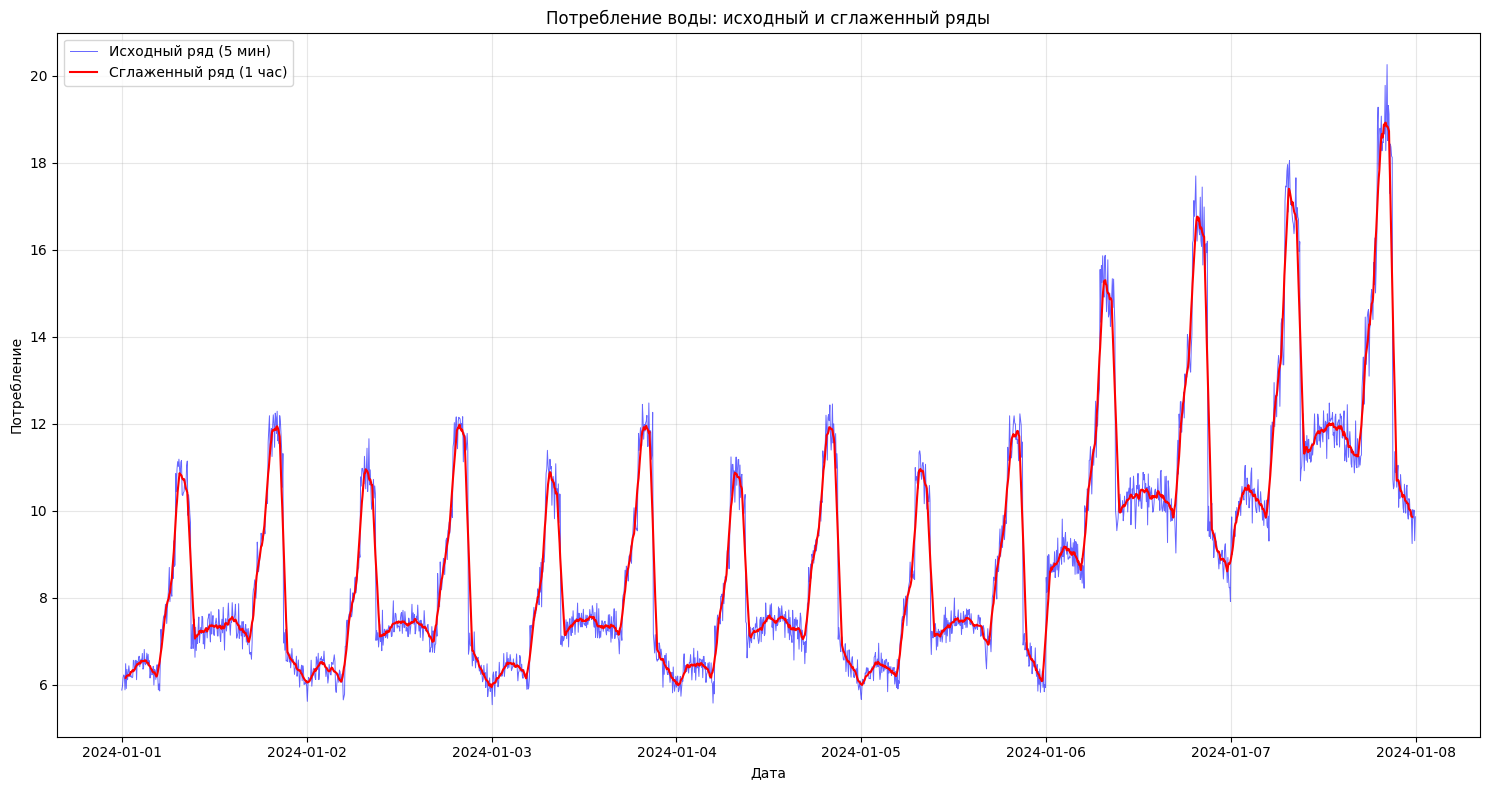

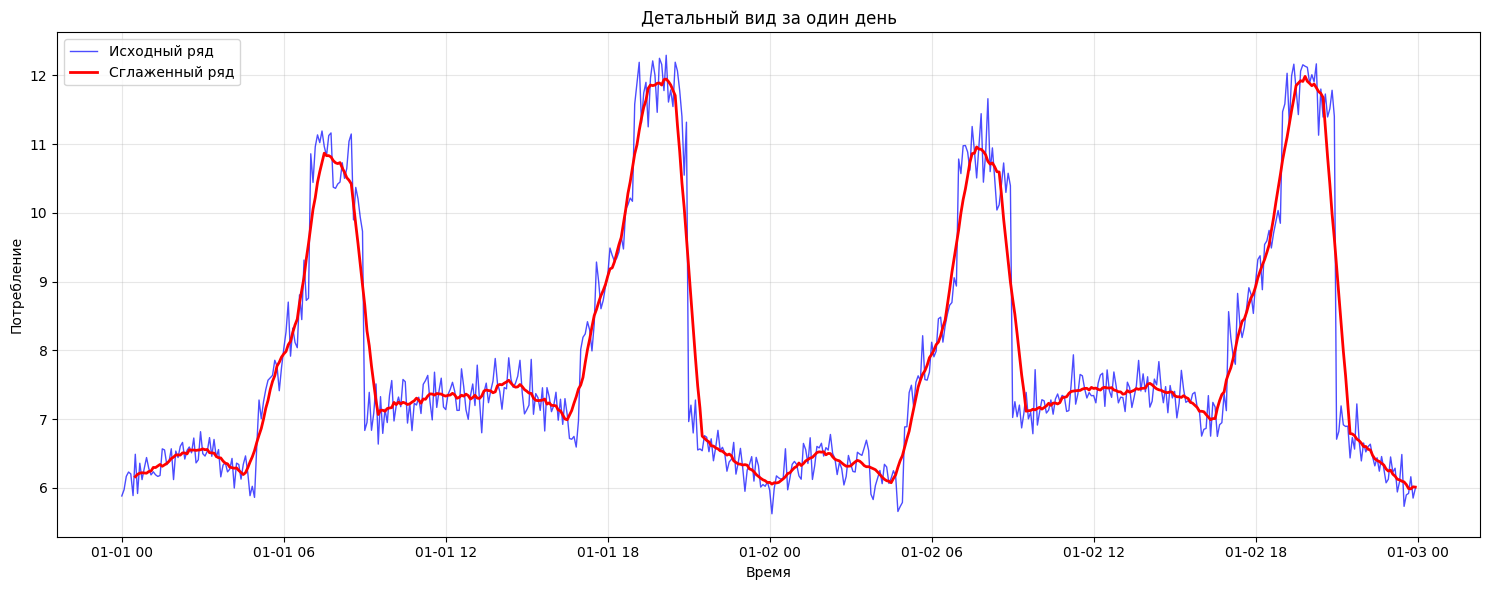

In [ ]:
# Сглаживание скользящим средним (окно 1 час = 12 интервалов по 5 минут)
smoothed_ts = water_ts_5min.rolling(window=12, center=True).mean()

# Визуализация исходного и сглаженного рядов
plt.figure(figsize=(15, 8))

# Исходный ряд
plt.plot(water_ts_5min.index, water_ts_5min.values,
         linewidth=0.7, alpha=0.6, label='Исходный ряд (5 мин)', color='blue')

# Сглаженный ряд
plt.plot(smoothed_ts.index, smoothed_ts.values,
         linewidth=1.5, label='Сглаженный ряд (1 час)', color='red')

plt.title('Потребление воды: исходный и сглаженный ряды')
plt.xlabel('Дата')
plt.ylabel('Потребление')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Детальный вид за один день
one_day_original = water_ts_5min['2024-01-01':'2024-01-02']
one_day_smoothed = smoothed_ts['2024-01-01':'2024-01-02']

plt.figure(figsize=(15, 6))
plt.plot(one_day_original.index, one_day_original.values,
         linewidth=1, alpha=0.7, label='Исходный ряд', color='blue')
plt.plot(one_day_smoothed.index, one_day_smoothed.values,
         linewidth=2, label='Сглаженный ряд', color='red')
plt.title('Детальный вид за один день')
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
ved = pd.read_excel('/content/drive/MyDrive/LDT_2025/Посуточная ведомость ОДПУ ГВС.xlsx')

In [ ]:
ved

,Дата,"Время суток, ч","Подача, м3","Обратка, м3","Потребление за период, м3","Т1 гвс, оС","Т2 гвс, оС"
0,01.04.2025,0-1,0.23,0.12,0.11,60,42
1,01.04.2025,1-2,0.09,0.05,0.04,60,42
2,01.04.2025,2-3,0.11,0.06,0.05,60,42
3,01.04.2025,3-4,0.11,0.06,0.05,60,42
4,01.04.2025,4-5,0.14,0.08,0.06,60,42
...,...,...,...,...,...,...,...
715,2025-04-30 00:00:00,19-20,0.00,0.00,0.00,48,27
716,2025-04-30 00:00:00,20-21,0.00,0.00,0.00,48,27
717,2025-04-30 00:00:00,21-22,0.00,0.00,0.00,48,27
718,2025-04-30 00:00:00,22-23,0.00,0.00,0.00,48,27


In [ ]:
ved['Время суток, ч'].value_counts()

,count
"Время суток, ч",
0-1,30
1-2,30
2-3,30
3-4,30
4-5,30
5-6,30
6-7,30
7-8,30
8-9,30


In [ ]:
ved.groupby(['Время суток, ч'])['Подача, м3'].mean()

,"Подача, м3"
"Время суток, ч",
0-1,0.162333
1-2,0.065333
10-11,0.259667
11-12,0.226333
12-13,0.324667
13-14,0.357000
14-15,0.390333
15-16,0.324667
16-17,0.293000


<Axes: >

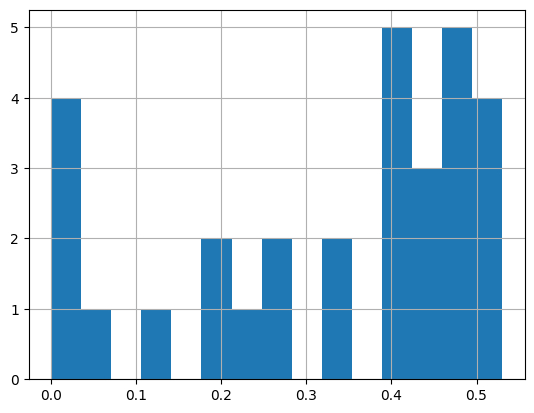

In [ ]:
ved[ved['Время суток, ч']=='8-9']['Подача, м3'].hist(bins=15)

<Axes: >

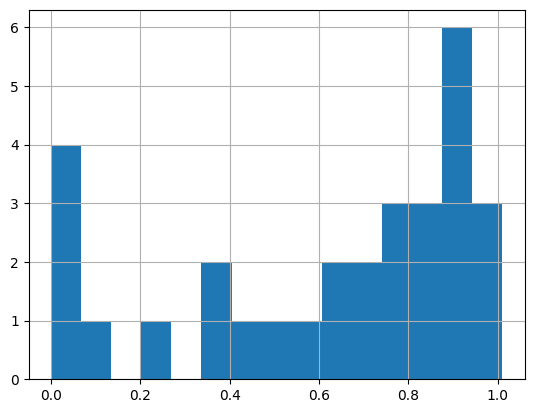

In [ ]:
ved[ved['Время суток, ч']=='19-20']['Подача, м3'].hist(bins=15)

<Axes: >

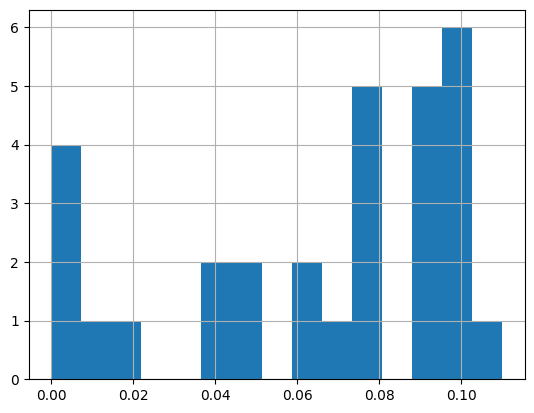

In [ ]:
ved[ved['Время суток, ч']=='1-2']['Подача, м3'].hist(bins=15)

<Axes: >

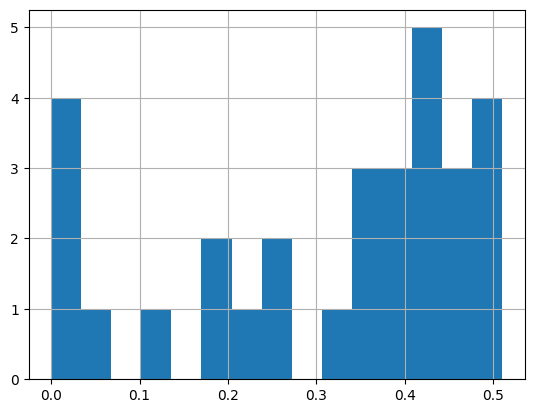

In [ ]:
ved[ved['Время суток, ч']=='5-6']['Подача, м3'].hist(bins=15)

In [ ]:
ved.groupby(['Время суток, ч'])['Подача, м3'].mean()

,"Подача, м3"
"Время суток, ч",
0-1,0.162333
1-2,0.065333
10-11,0.259667
11-12,0.226333
12-13,0.324667
13-14,0.357000
14-15,0.390333
15-16,0.324667
16-17,0.293000


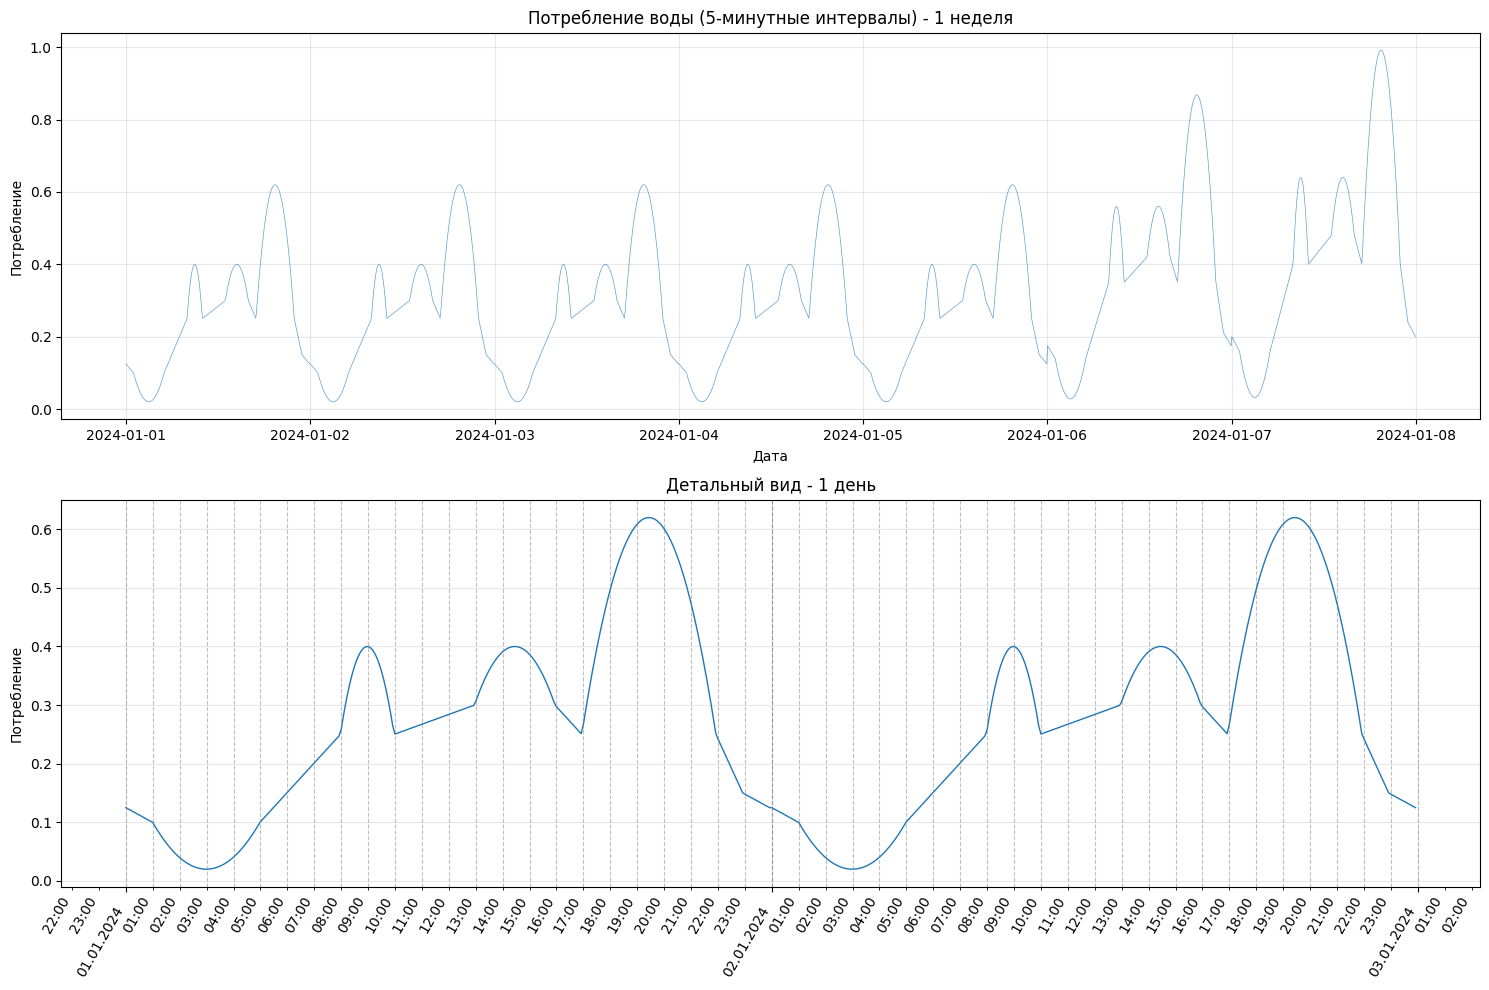

Статистика данных:
Всего точек: 2016
Период: 2024-01-01 00:00:00 - 2024-01-07 23:55:00
Среднее потребление: 0.31
Максимальное потребление: 0.99
Минимальное потребление: 0.02


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_water_usage_5min(days=30, noise_level=0.0, base_consumption=0.00):
    """
    Генерация временного ряда потребления воды с 5-минутным интервалом
    с суточной и недельной сезонностью
    """
    # Параметры
    minutes_per_hour = 12  # 5 минутные интервалы (60/5 = 12)
    hours_per_day = 24
    days_per_week = 7
    total_intervals = days * hours_per_day * minutes_per_hour

    # Создание временного индекса
    date_range = pd.date_range(start='2024-01-01', periods=total_intervals, freq='5min')

    # Детальный суточный паттерн (5-минутные интервалы)
    # Более плавные переходы между пиками
    time_slots = np.linspace(0, 24, minutes_per_hour * hours_per_day)
    hourly_pattern = np.zeros_like(time_slots)


    # Заполнение паттерна потребления с обновленными ночными значениями
    for i, hour in enumerate(time_slots):
        if hour < 1 or hour >= 23:  # 23-1 часа: линейное падение
            if hour >= 23:
                transition = (hour - 23) / 2  # 2 часа от 23 до 1
                start_value = 0.15
                end_value = 0.1  # новое значение в 1:00
            else:  # hour < 1
                transition = (hour + 1) / 2  # от 0 до 1 (0:00 до 1:00)
                start_value = 0.15
                end_value = 0.1  # новое значение в 1:00
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 5:    # 1-5 часов: парабола вершиной вниз
            # Полная парабола от 1 до 5 часов с минимумом в 3 часа
            t = (hour - 1) / 4  # нормализация от 0 до 1
            # Парабола проходит через: (0, 0.1), (0.5, 0.02), (1, 0.1)
            # Формула: a*(t-0.5)^2 + 0.02
            # При t=0: a*(0-0.5)^2 + 0.02 = a*0.25 + 0.02 = 0.1
            # Решаем: 0.25a + 0.02 = 0.1 → 0.25a = 0.08 → a = 0.32
            a = 0.32
            hourly_pattern[i] = a * (t - 0.5)**2 + 0.02

        elif hour < 8:    # 5-8 часов: линейный рост
            # Линейный рост от 0.1 в 5:00 до 0.25 в 8:00
            start_value = 0.1   # новое значение в 5:00
            end_value = 0.25
            transition = (hour - 5) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 10:   # 8-10 часов: полная парабола вершиной вверх
            t = (hour - 8) / 2
            a = 0.6
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4

        elif hour < 13:   # 10-13 часов: слабый линейный рост
            start_value = 0.25
            end_value = 0.3
            transition = (hour - 10) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 16:   # 13-16 часов: полная парабола вершиной вверх
            t = (hour - 13) / 3
            a = 0.4
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4

        elif hour < 17:   # 16-17 часов: небольшое падение
            start_value = 0.3
            end_value = 0.25
            transition = (hour - 16) / 1
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 22:   # 17-22 часов: полная парабола вершиной вверх
            t = (hour - 17) / 5
            a = 1.48
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.62

        else:             # 22-23 часов: линейное падение
            # Линейный спад от 0.25 в 22:00 до 0.15 в 23:00
            start_value = 0.25
            end_value = 0.15
            transition = (hour - 22) / 1
            hourly_pattern[i] = start_value + (end_value - start_value) * transition



    # Недельная сезонность
    daily_multiplier = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.6])  # выходные выше

    # Генерация ряда
    ts = []
    for i, timestamp in enumerate(date_range):
        # Индекс в суточном паттерне
        total_minutes = timestamp.hour * 60 + timestamp.minute
        pattern_idx = int(total_minutes / 5)

        day_of_week = timestamp.dayofweek

        # Базовое значение + суточный паттерн
        value = base_consumption + hourly_pattern[pattern_idx % len(hourly_pattern)]

        # Умножение на недельный коэффициент
        value *= daily_multiplier[day_of_week]

        # Добавление случайных всплесков (кратковременное увеличение потребления)
        #if np.random.random() < 0.02:  # 2% chance of spike
        #    value += np.random.exponential(3)

        # Добавление шума
        noise = np.random.normal(0, noise_level * value)
        value += noise

        ts.append(max(0.0, value))  # избегаем отрицательных значений

    return pd.Series(ts, index=date_range, name='water_consumption')

# Генерация данных
water_ts_5min = generate_water_usage_5min(days=7)  # 1 неделя для наглядности

# Визуализация
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Полная неделя
ax1.plot(water_ts_5min.index, water_ts_5min.values, linewidth=0.5, alpha=0.7)
ax1.set_title('Потребление воды (5-минутные интервалы) - 1 неделя')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Потребление')
ax1.grid(True, alpha=0.3)

# Настройка для одного дня
one_day = water_ts_5min['2024-01-01':'2024-01-02']
ax2.plot(one_day.index, one_day.values, linewidth=1)
ax2.set_title('Детальный вид - 1 день')
ax2.set_ylabel('Потребление')

# Добавляем вертикальные линии каждый час для обоих дней
start_date = pd.Timestamp('2024-01-01')
for day_offset in range(2):  # для двух дней
    for hour in range(25):  # от 0 до 24 часов
        hour_time = start_date + pd.Timedelta(days=day_offset, hours=hour)
        ax2.axvline(x=hour_time, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# Настраиваем подписи: основная подпись - дата, второстепенные - часы
ax2.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('\n%d.%m.%Y'))
# Поворачиваем подписи часов на 45 градусов
for label in ax2.xaxis.get_majorticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

ax2.xaxis.set_minor_locator(plt.matplotlib.dates.HourLocator(interval=1))
ax2.xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

# Поворачиваем подписи часов на 45 градусов
for label in ax2.xaxis.get_minorticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print("Статистика данных:")
print(f"Всего точек: {len(water_ts_5min)}")
print(f"Период: {water_ts_5min.index[0]} - {water_ts_5min.index[-1]}")
print(f"Среднее потребление: {water_ts_5min.mean():.2f}")
print(f"Максимальное потребление: {water_ts_5min.max():.2f}")
print(f"Минимальное потребление: {water_ts_5min.min():.2f}")

In [ ]:
ved.groupby(['Время суток, ч'])['Подача, м3'].mean()

,"Подача, м3"
"Время суток, ч",
0-1,0.162333
1-2,0.065333
10-11,0.259667
11-12,0.226333
12-13,0.324667
13-14,0.357000
14-15,0.390333
15-16,0.324667
16-17,0.293000


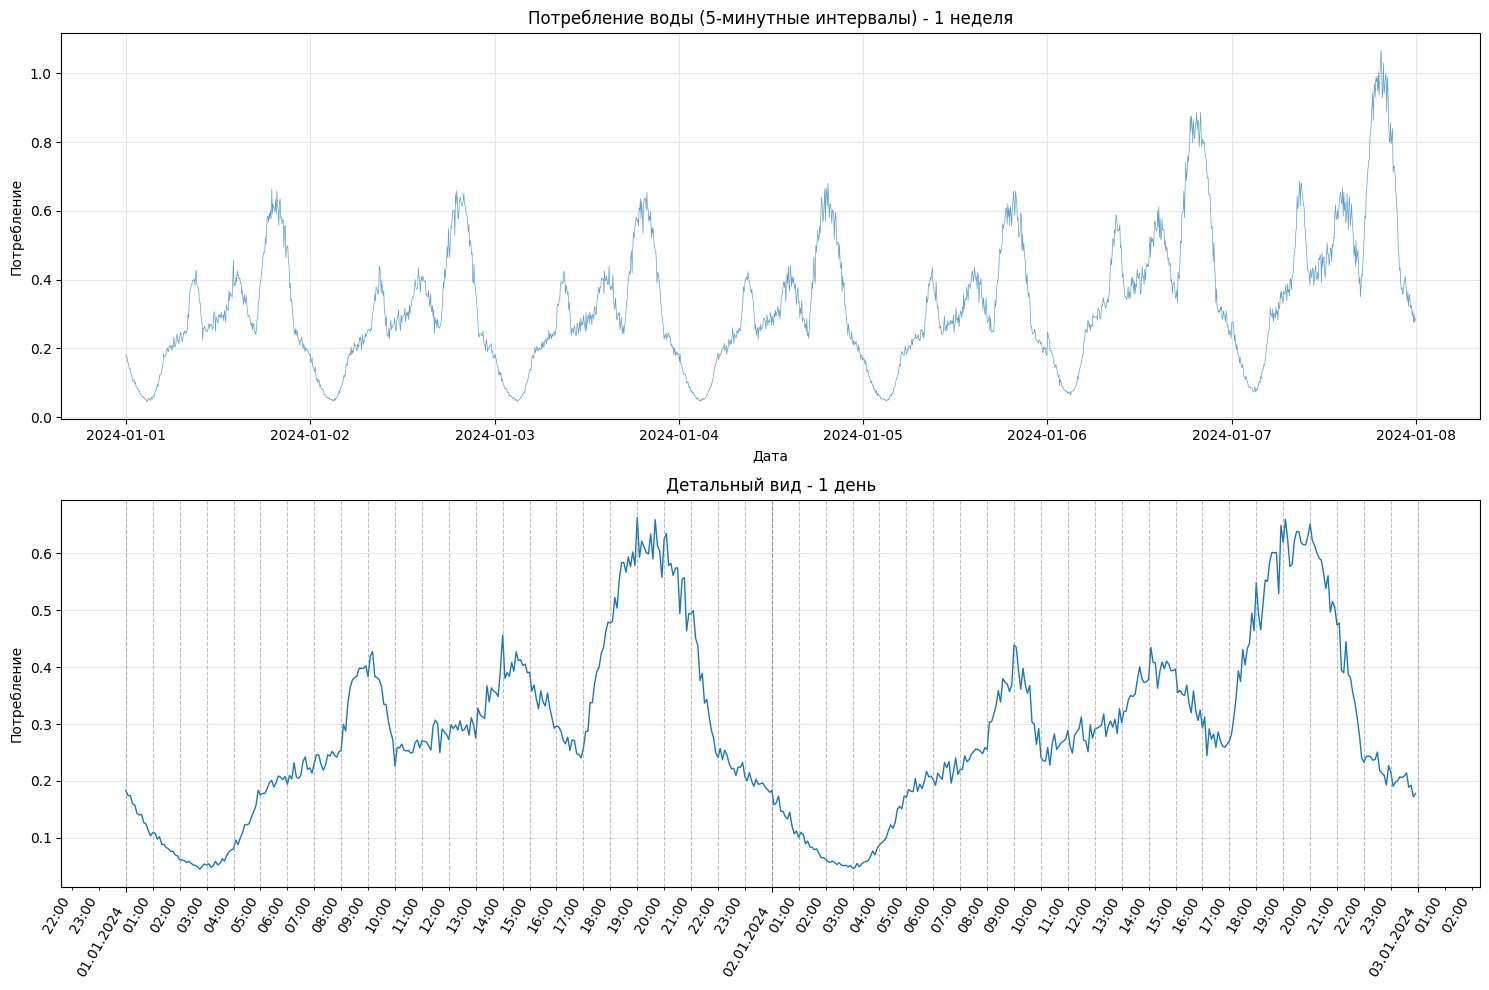

Статистика данных:
Всего точек: 2016
Период: 2024-01-01 00:00:00 - 2024-01-07 23:55:00
Среднее потребление: 0.33
Максимальное потребление: 1.07
Минимальное потребление: 0.05


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_water_usage_5min(days=30, noise_level=0.05, base_consumption=0.00):
    """
    Генерация временного ряда потребления воды с 5-минутным интервалом
    с суточной и недельной сезонностью
    """
    # Параметры
    minutes_per_hour = 12  # 5 минутные интервалы (60/5 = 12)
    hours_per_day = 24
    days_per_week = 7
    total_intervals = days * hours_per_day * minutes_per_hour

    # Создание временного индекса
    date_range = pd.date_range(start='2024-01-01', periods=total_intervals, freq='5min')

    # Детальный суточный паттерн (5-минутные интервалы)
    # Более плавные переходы между пиками
    time_slots = np.linspace(0, 24, minutes_per_hour * hours_per_day)
    hourly_pattern = np.zeros_like(time_slots)


    # Заполнение паттерна потребления с раздельными параболами
    for i, hour in enumerate(time_slots):
        if hour < 3:    # 0-3 часов: левая часть параболы
            # Парабола от 0 до 3 часов с минимумом в 3:00
            t = (hour - 0) / 3  # нормализация от 0 до 1
            # Парабола проходит через: (0, 0.18), (1, 0.05)
            # Формула: a*(t-1)^2 + 0.05
            # При t=0: a*(0-1)^2 + 0.05 = a*1 + 0.05 = 0.18
            # Решаем: a + 0.05 = 0.18 → a = 0.13
            a = 0.13
            hourly_pattern[i] = a * (t - 1)**2 + 0.05

        elif hour < 5:    # 3-5 часов: правая часть параболы
            # Парабола от 3 до 5 часов с минимумом в 3:00
            t = (hour - 3) / 2  # нормализация от 0 до 1
            # Парабола проходит через: (0, 0.05), (1, 0.18)
            # Формула: a*t^2 + 0.05
            # При t=1: a*1^2 + 0.05 = a + 0.05 = 0.18
            # Решаем: a + 0.05 = 0.18 → a = 0.13
            a = 0.13
            hourly_pattern[i] = a * t**2 + 0.05

        elif hour < 8:    # 5-8 часов: линейный рост
            # Линейный рост от 0.18 в 5:00 до 0.25 в 8:00
            start_value = 0.18
            end_value = 0.25
            transition = (hour - 5) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 10:   # 8-10 часов: полная парабола вершиной вверх
            t = (hour - 8) / 2
            a = 0.6
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4

        elif hour < 13:   # 10-13 часов: слабый линейный рост
            start_value = 0.25
            end_value = 0.3
            transition = (hour - 10) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 16:   # 13-16 часов: полная парабола вершиной вверх
            t = (hour - 13) / 3
            a = 0.4
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4

        elif hour < 17:   # 16-17 часов: небольшое падение
            start_value = 0.3
            end_value = 0.25
            transition = (hour - 16) / 1
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 22:   # 17-22 часов: полная парабола вершиной вверх
            t = (hour - 17) / 5
            a = 1.48
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.62

        else:             # 22-24 часов: линейное падение
            # Линейный спад от 0.25 в 22:00 до 0.18 в 24:00
            start_value = 0.25
            end_value = 0.18
            transition = (hour - 22) / 2
            hourly_pattern[i] = start_value + (end_value - start_value) * transition



    # Недельная сезонность
    daily_multiplier = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.6])  # выходные выше

    # Генерация ряда
    ts = []
    for i, timestamp in enumerate(date_range):
        # Индекс в суточном паттерне
        total_minutes = timestamp.hour * 60 + timestamp.minute
        pattern_idx = int(total_minutes / 5)

        day_of_week = timestamp.dayofweek

        # Базовое значение + суточный паттерн
        value = base_consumption + hourly_pattern[pattern_idx % len(hourly_pattern)]

        # Умножение на недельный коэффициент
        value *= daily_multiplier[day_of_week]

        # Добавление случайных всплесков (кратковременное увеличение потребления)
        #if np.random.random() < 0.02:  # 2% chance of spike
        #    value += np.random.exponential(3)

        # Добавление шума
        noise = np.random.normal(0, noise_level * value)
        value += noise

        ts.append(max(0.0, value))  # убираем отрицательные

    return pd.Series(ts, index=date_range, name='water_consumption')

# Генерация данных
water_ts_5min = generate_water_usage_5min(days=7)  # 1 неделя для наглядности

# Визуализация
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Полная неделя
ax1.plot(water_ts_5min.index, water_ts_5min.values, linewidth=0.5, alpha=0.7)
ax1.set_title('Потребление воды (5-минутные интервалы) - 1 неделя')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Потребление')
ax1.grid(True, alpha=0.3)

# Настройка для одного дня
one_day = water_ts_5min['2024-01-01':'2024-01-02']
ax2.plot(one_day.index, one_day.values, linewidth=1)
ax2.set_title('Детальный вид - 1 день')
ax2.set_ylabel('Потребление')

# Добавляем вертикальные линии каждый час для обоих дней
start_date = pd.Timestamp('2024-01-01')
for day_offset in range(2):  # для двух дней
    for hour in range(25):  # от 0 до 24 часов
        hour_time = start_date + pd.Timedelta(days=day_offset, hours=hour)
        ax2.axvline(x=hour_time, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# Настраиваем подписи: основная подпись - дата, второстепенные - часы
ax2.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('\n%d.%m.%Y'))
# Поворачиваем подписи часов на 45 градусов
for label in ax2.xaxis.get_majorticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

ax2.xaxis.set_minor_locator(plt.matplotlib.dates.HourLocator(interval=1))
ax2.xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

# Поворачиваем подписи часов на 45 градусов
for label in ax2.xaxis.get_minorticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print("Статистика данных:")
print(f"Всего точек: {len(water_ts_5min)}")
print(f"Период: {water_ts_5min.index[0]} - {water_ts_5min.index[-1]}")
print(f"Среднее потребление: {water_ts_5min.mean():.2f}")
print(f"Максимальное потребление: {water_ts_5min.max():.2f}")
print(f"Минимальное потребление: {water_ts_5min.min():.2f}")

### Другая функция, без резкого скачка в субботу

In [ ]:
def generate_water_usage_5min(days=30, noise_level=0.05, base_consumption=0.00):
    """
    Генерация временного ряда потребления воды с 5-минутным интервалом
    с суточной и недельной сезонностью
    """
    # Параметры
    minutes_per_hour = 12  # 5 минутные интервалы (60/5 = 12)
    hours_per_day = 24
    days_per_week = 7
    total_intervals = days * hours_per_day * minutes_per_hour

    # Создание временного индекса
    date_range = pd.date_range(start='2024-01-01', periods=total_intervals, freq='5min')

    # Детальный суточный паттерн (5-минутные интервалы)
    time_slots = np.linspace(0, 24, minutes_per_hour * hours_per_day)
    hourly_pattern = np.zeros_like(time_slots)

    # Заполнение паттерна потребления (остается без изменений)
    for i, hour in enumerate(time_slots):
        if hour < 3:
            t = (hour - 0) / 3
            a = 0.13
            hourly_pattern[i] = a * (t - 1)**2 + 0.05
        elif hour < 5:
            t = (hour - 3) / 2
            a = 0.13
            hourly_pattern[i] = a * t**2 + 0.05
        elif hour < 8:
            start_value = 0.18
            end_value = 0.25
            transition = (hour - 5) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition
        elif hour < 10:
            t = (hour - 8) / 2
            a = 0.6
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4
        elif hour < 13:
            start_value = 0.25
            end_value = 0.3
            transition = (hour - 10) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition
        elif hour < 16:
            t = (hour - 13) / 3
            a = 0.4
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4
        elif hour < 17:
            start_value = 0.3
            end_value = 0.25
            transition = (hour - 16) / 1
            hourly_pattern[i] = start_value + (end_value - start_value) * transition
        elif hour < 22:
            t = (hour - 17) / 5
            a = 1.48
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.62
        else:
            start_value = 0.25
            end_value = 0.18
            transition = (hour - 22) / 2
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

    # Базовые коэффициенты сезонности
    base_multiplier = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.6])

    # Генерация ряда
    ts = []
    for i, timestamp in enumerate(date_range):
        # Индекс в суточном паттерне
        total_minutes = timestamp.hour * 60 + timestamp.minute
        pattern_idx = int(total_minutes / 5)
        day_of_week = timestamp.dayofweek

        # Базовое значение + суточный паттерн
        value = base_consumption + hourly_pattern[pattern_idx % len(hourly_pattern)]
        value = max(0.0, value)

        # Плавное применение коэффициента сезонности для выходных
        if day_of_week in [5, 6]:  # суббота и воскресенье
            # Плавное увеличение коэффициента с 4:00 до 10:00
            if timestamp.hour < 4:
                # До 4 утра - базовый коэффициент
                multiplier = 1.0
            elif timestamp.hour < 10:
                # С 4 до 10 утра - плавный переход к полному коэффициенту
                transition = (timestamp.hour - 4 + timestamp.minute/60) / 6  # 6 часов
                base_coef = 1.0
                target_coef = base_multiplier[day_of_week]
                multiplier = base_coef + (target_coef - base_coef) * min(transition, 1.0)
            else:
                # После 10 утра - полный коэффициент
                multiplier = base_multiplier[day_of_week]
        else:
            # Будние дни - базовый коэффициент
            multiplier = 1.0

        value *= multiplier

        # Добавление шума
        noise = np.random.normal(0, noise_level * value)
        value += noise

        ts.append(max(0.0, value))

    return pd.Series(ts, index=date_range)

In [ ]:
def generate_water_usage_5min(days=30, noise_level=0.05, base_consumption=0.00):
    """
    Генерация временного ряда потребления воды с 5-минутным интервалом
    с суточной и недельной сезонностью
    """
    # Параметры
    minutes_per_hour = 12  # 5 минутные интервалы (60/5 = 12)
    hours_per_day = 24
    days_per_week = 7
    total_intervals = days * hours_per_day * minutes_per_hour

    # Создание временного индекса
    date_range = pd.date_range(start='2024-01-01', periods=total_intervals, freq='5min')

    # Детальный суточный паттерн (5-минутные интервалы)
    time_slots = np.linspace(0, 24, minutes_per_hour * hours_per_day)
    hourly_pattern = np.zeros_like(time_slots)

    # Заполнение паттерна потребления
    for i, hour in enumerate(time_slots):
        if hour < 3:
            t = (hour - 0) / 3
            a = 0.13
            hourly_pattern[i] = a * (t - 1)**2 + 0.05
        elif hour < 5:
            t = (hour - 3) / 2
            a = 0.13
            hourly_pattern[i] = a * t**2 + 0.05
        elif hour < 8:
            start_value = 0.18
            end_value = 0.25
            transition = (hour - 5) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition
        elif hour < 10:
            t = (hour - 8) / 2
            a = 0.6
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4
        elif hour < 13:
            start_value = 0.25
            end_value = 0.3
            transition = (hour - 10) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition
        elif hour < 16:
            t = (hour - 13) / 3
            a = 0.4
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4
        elif hour < 17:
            start_value = 0.3
            end_value = 0.25
            transition = (hour - 16) / 1
            hourly_pattern[i] = start_value + (end_value - start_value) * transition
        elif hour < 22:
            t = (hour - 17) / 5
            a = 1.48
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.62
        else:
            start_value = 0.25
            end_value = 0.18
            transition = (hour - 22) / 2
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

    # Базовые коэффициенты сезонности
    base_multiplier = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.6])  # пн-вс

    # Генерация ряда
    ts = []
    for i, timestamp in enumerate(date_range):
        # Индекс в суточном паттерне
        total_minutes = timestamp.hour * 60 + timestamp.minute
        pattern_idx = int(total_minutes / 5)
        day_of_week = timestamp.dayofweek
        hour_of_day = timestamp.hour + timestamp.minute/60

        # Базовое значение + суточный паттерн
        value = base_consumption + hourly_pattern[pattern_idx % len(hourly_pattern)]
        value = max(0.0, value)

        # Определяем коэффициенты для текущего и следующего дня
        current_day_coef = base_multiplier[day_of_week]
        next_day_coef = base_multiplier[(day_of_week + 1) % 7]

        # Плавные переходы между днями
        if hour_of_day < 4:
            # Ночь (0:00-4:00) - плавный переход от предыдущего дня к текущему
            transition = hour_of_day / 4  # 0 до 1 за 4 часа
            prev_day_coef = base_multiplier[(day_of_week - 1) % 7]
            multiplier = prev_day_coef + (current_day_coef - prev_day_coef) * transition
        elif hour_of_day < 10:
            # Утро (4:00-10:00) - плавный переход к полному коэффициенту текущего дня
            transition = (hour_of_day - 4) / 6  # 0 до 1 за 6 часов
            night_coef = current_day_coef  # уже перешли к текущему дню
            full_coef = current_day_coef
            # Для выходных увеличиваем коэффициент, для будних оставляем 1.0
            if day_of_week in [5, 6]:  # суббота и воскресенье
                full_coef = current_day_coef
            multiplier = night_coef + (full_coef - night_coef) * min(transition, 1.0)
        elif hour_of_day < 22:
            # День (10:00-22:00) - полный коэффициент
            multiplier = current_day_coef
        else:
            # Вечер-ночь (22:00-24:00) - плавный переход к следующему дню
            transition = (hour_of_day - 22) / 2  # 0 до 1 за 2 часа
            multiplier = current_day_coef + (next_day_coef - current_day_coef) * transition

        value *= multiplier

        # Добавление шума
        noise = np.random.normal(0, noise_level * value)
        value += noise

        ts.append(max(0.0, value))

    return pd.Series(ts, index=date_range, name='water_consumption')

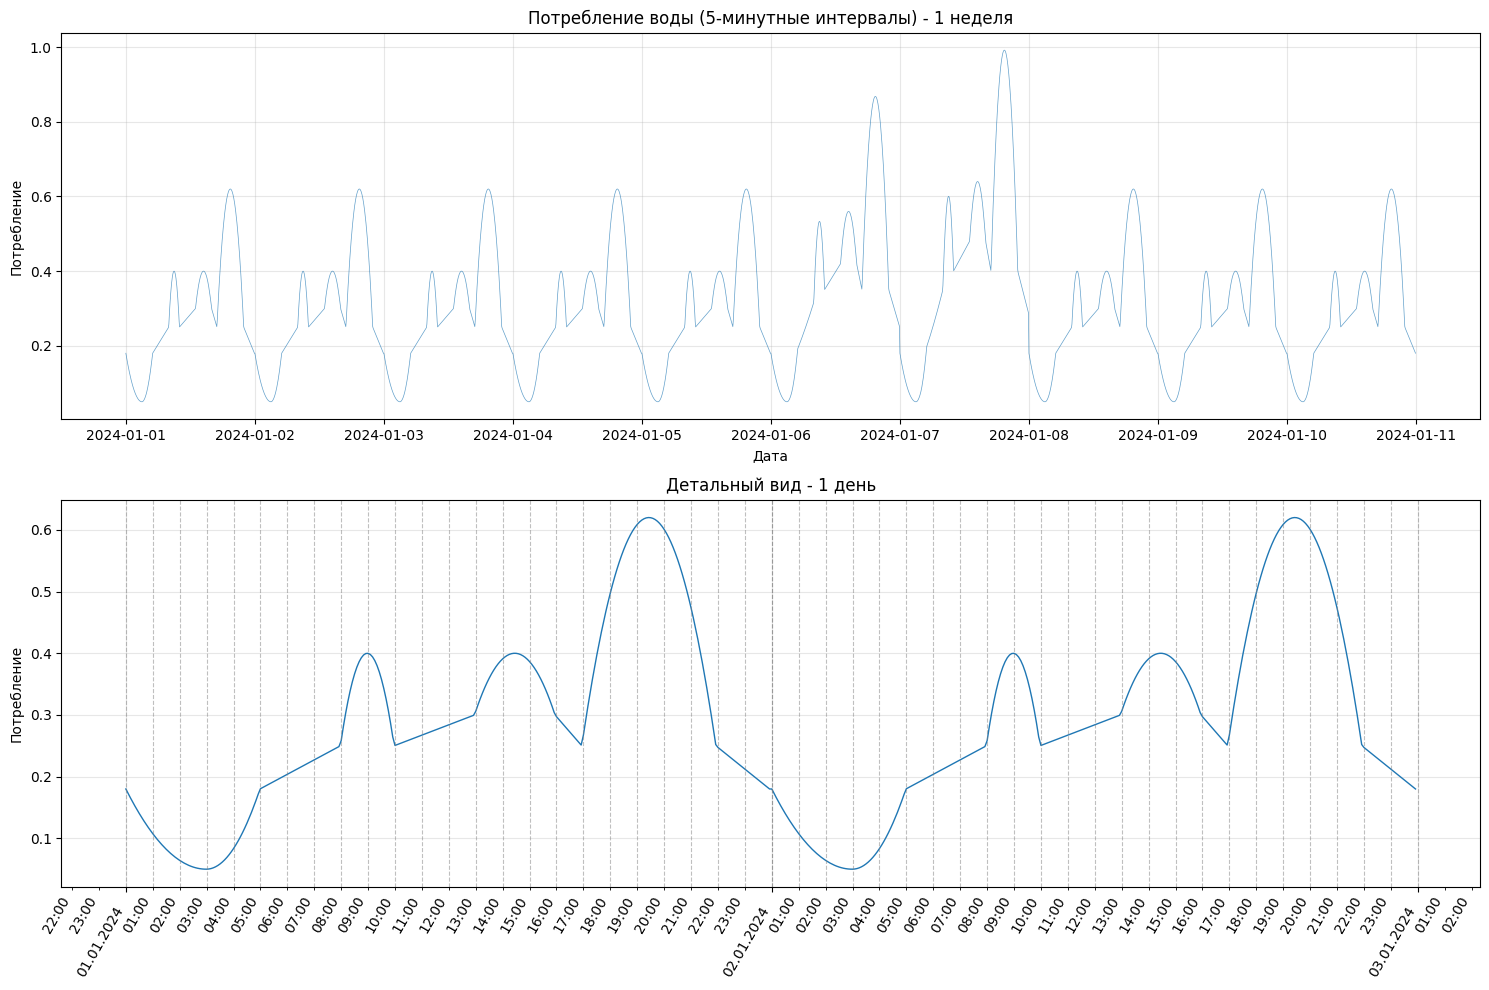

Статистика данных:
Всего точек: 2880
Период: 2024-01-01 00:00:00 - 2024-01-10 23:55:00
Среднее потребление: 0.31
Максимальное потребление: 0.99
Минимальное потребление: 0.05


In [ ]:
# Генерация данных
water_ts_5min = generate_water_usage_5min(days=10,noise_level=0.0)  # 1 неделя для наглядности

# Визуализация
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Полная неделя
ax1.plot(water_ts_5min.index, water_ts_5min.values, linewidth=0.5, alpha=0.7)
ax1.set_title('Потребление воды (5-минутные интервалы) - 1 неделя')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Потребление')
ax1.grid(True, alpha=0.3)

# Настройка для одного дня
one_day = water_ts_5min['2024-01-01':'2024-01-02']
ax2.plot(one_day.index, one_day.values, linewidth=1)
ax2.set_title('Детальный вид - 1 день')
ax2.set_ylabel('Потребление')

# Добавляем вертикальные линии каждый час для обоих дней
start_date = pd.Timestamp('2024-01-01')
for day_offset in range(2):  # для двух дней
    for hour in range(25):  # от 0 до 24 часов
        hour_time = start_date + pd.Timedelta(days=day_offset, hours=hour)
        ax2.axvline(x=hour_time, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# Настраиваем подписи: основная подпись - дата, второстепенные - часы
ax2.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('\n%d.%m.%Y'))
# Поворачиваем подписи часов на 45 градусов
for label in ax2.xaxis.get_majorticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

ax2.xaxis.set_minor_locator(plt.matplotlib.dates.HourLocator(interval=1))
ax2.xaxis.set_minor_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

# Поворачиваем подписи часов на 45 градусов
for label in ax2.xaxis.get_minorticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print("Статистика данных:")
print(f"Всего точек: {len(water_ts_5min)}")
print(f"Период: {water_ts_5min.index[0]} - {water_ts_5min.index[-1]}")
print(f"Среднее потребление: {water_ts_5min.mean():.2f}")
print(f"Максимальное потребление: {water_ts_5min.max():.2f}")
print(f"Минимальное потребление: {water_ts_5min.min():.2f}")

все равно не то

### Сглаживание

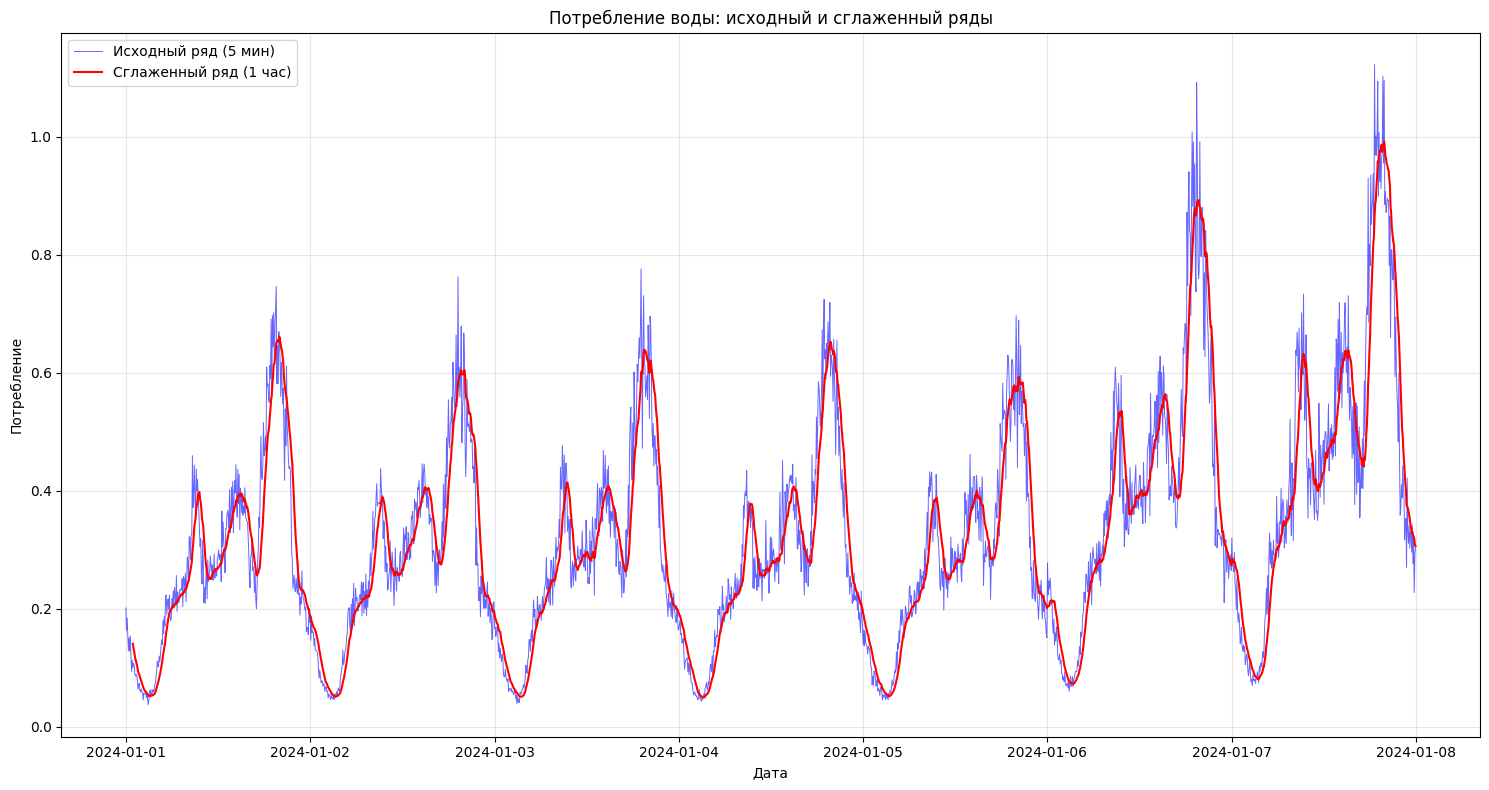

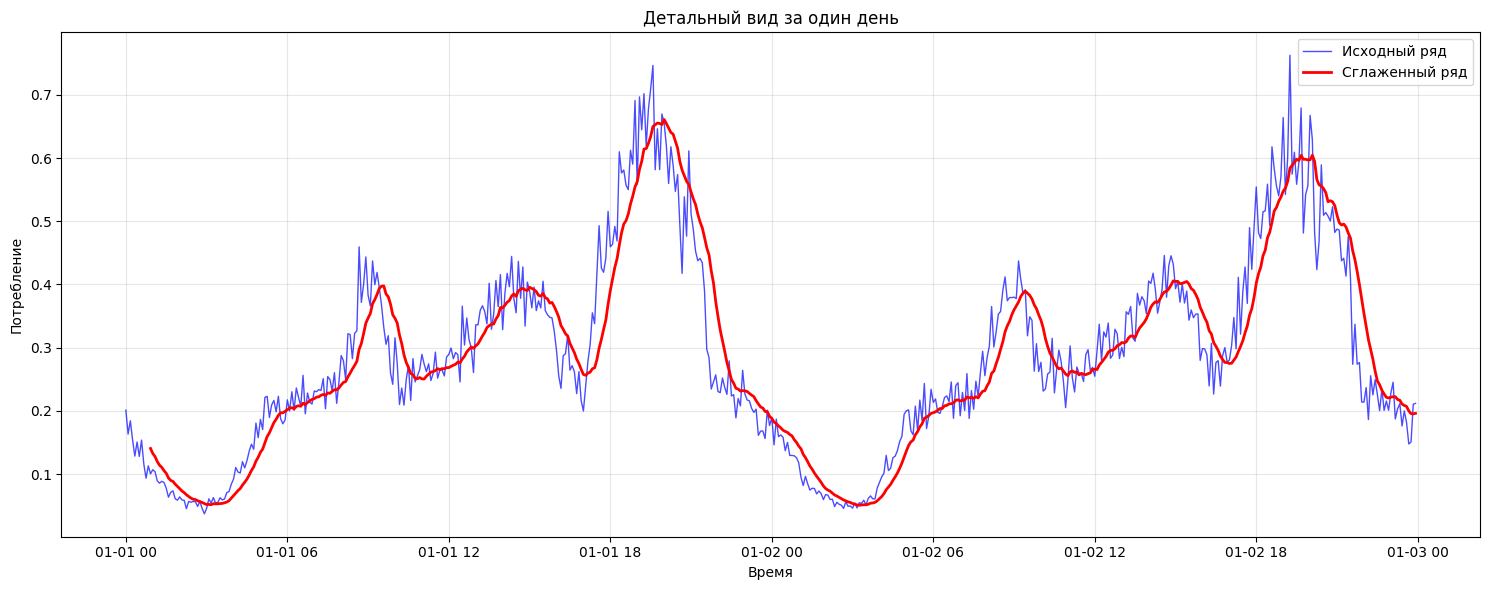

In [ ]:
# Сглаживание скользящим средним (окно 1 час = 12 интервалов по 5 минут)
smoothed_ts = water_ts_5min.rolling(window=12).mean()

# Визуализация исходного и сглаженного рядов
plt.figure(figsize=(15, 8))

# Исходный ряд
plt.plot(water_ts_5min.index, water_ts_5min.values,
         linewidth=0.7, alpha=0.6, label='Исходный ряд (5 мин)', color='blue')

# Сглаженный ряд
plt.plot(smoothed_ts.index, smoothed_ts.values,
         linewidth=1.5, label='Сглаженный ряд (1 час)', color='red')

plt.title('Потребление воды: исходный и сглаженный ряды')
plt.xlabel('Дата')
plt.ylabel('Потребление')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Детальный вид за один день
one_day_original = water_ts_5min['2024-01-01':'2024-01-02']
one_day_smoothed = smoothed_ts['2024-01-01':'2024-01-02']

plt.figure(figsize=(15, 6))
plt.plot(one_day_original.index, one_day_original.values,
         linewidth=1, alpha=0.7, label='Исходный ряд', color='blue')
plt.plot(one_day_smoothed.index, one_day_smoothed.values,
         linewidth=2, label='Сглаженный ряд', color='red')
plt.title('Детальный вид за один день')
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

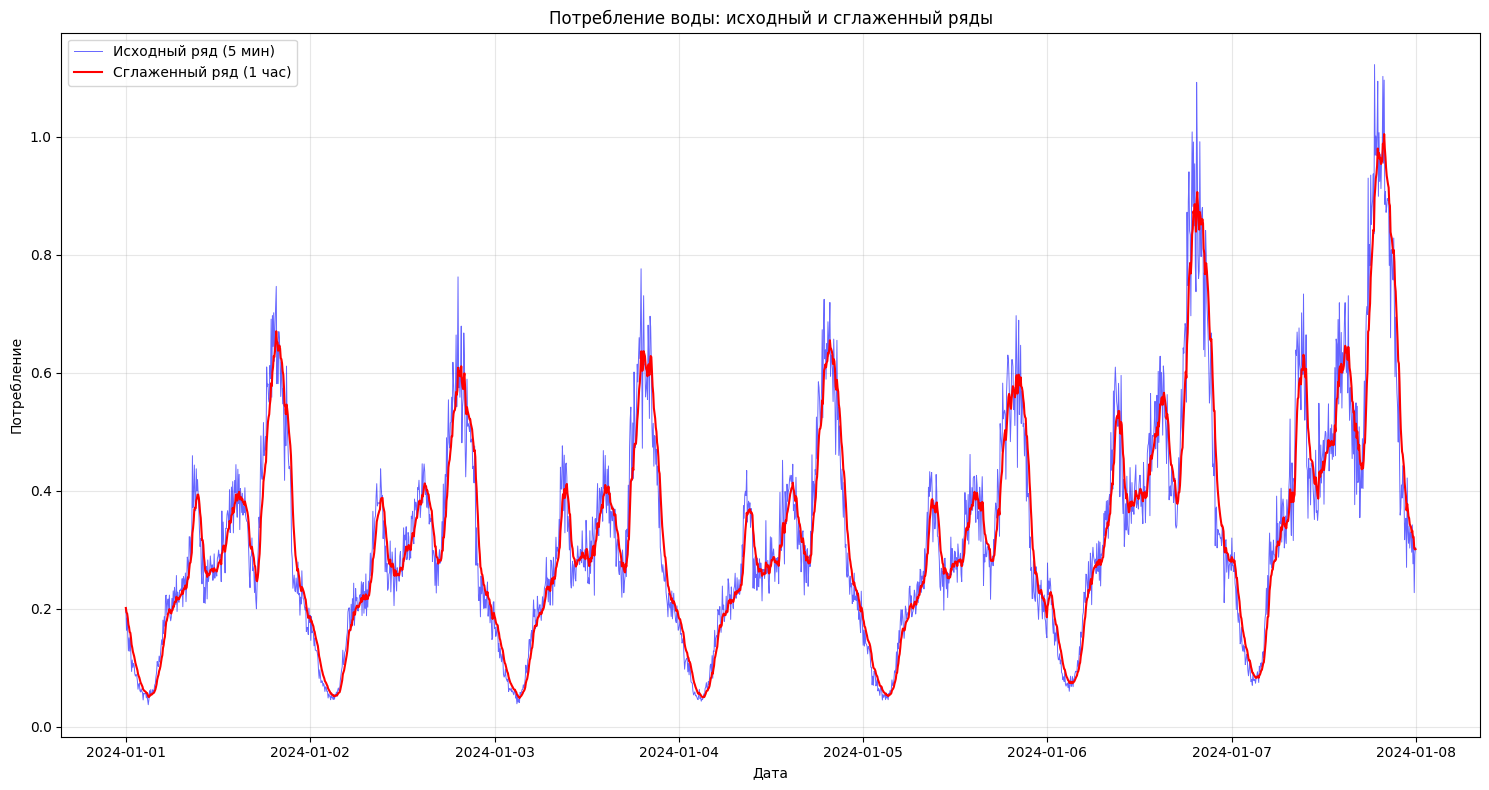

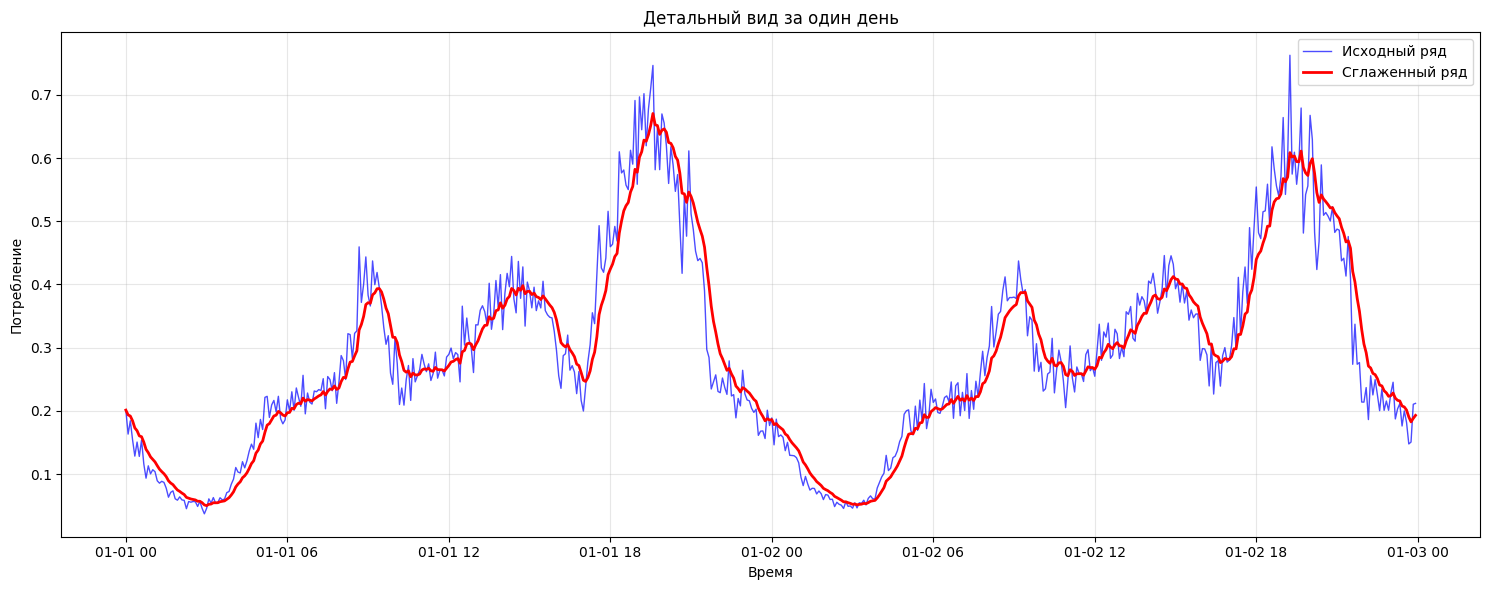

In [ ]:
# Экспоненциальное сглаживание с акцентом на последние значения
smoothed_ewm = water_ts_5min.ewm(
    alpha=0.2,        # коэффициент сглаживания (0 < alpha ≤ 1)
    adjust=False,
    ignore_na=False
).mean()

# Визуализация исходного и сглаженного рядов
plt.figure(figsize=(15, 8))

# Исходный ряд
plt.plot(water_ts_5min.index, water_ts_5min.values,
         linewidth=0.7, alpha=0.6, label='Исходный ряд (5 мин)', color='blue')

# Сглаженный ряд
plt.plot(smoothed_ewm.index, smoothed_ewm.values,
         linewidth=1.5, label='Сглаженный ряд (1 час)', color='red')

plt.title('Потребление воды: исходный и сглаженный ряды')
plt.xlabel('Дата')
plt.ylabel('Потребление')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Детальный вид за один день
one_day_original = water_ts_5min['2024-01-01':'2024-01-02']
one_day_smoothed = smoothed_ewm['2024-01-01':'2024-01-02']

plt.figure(figsize=(15, 6))
plt.plot(one_day_original.index, one_day_original.values,
         linewidth=1, alpha=0.7, label='Исходный ряд', color='blue')
plt.plot(one_day_smoothed.index, one_day_smoothed.values,
         linewidth=2, label='Сглаженный ряд', color='red')
plt.title('Детальный вид за один день')
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Генерация временных рядов  
Уровень шума от 7 до 12 %, базовое потребление +- 0.1

In [ ]:
def generate_water_(id_house, noise_level, base_consumption, days=120):
    """
    Генерация временного ряда потребления воды с 5-минутным интервалом
    с суточной и недельной сезонностью
    """
    # Параметры
    minutes_per_hour = 12  # 5 минутные интервалы (60/5 = 12)
    hours_per_day = 24
    days_per_week = 7
    total_intervals = days * hours_per_day * minutes_per_hour

    # Создание временного индекса
    date_range = pd.date_range(start='2025-09-01', periods=total_intervals, freq='5min')

    # Детальный суточный паттерн (5-минутные интервалы)
    # Более плавные переходы между пиками
    time_slots = np.linspace(0, 24, minutes_per_hour * hours_per_day)
    hourly_pattern = np.zeros_like(time_slots)


    # Заполнение паттерна потребления с раздельными параболами
    for i, hour in enumerate(time_slots):
        if hour < 3:    # 0-3 часов: левая часть параболы
            # Парабола от 0 до 3 часов с минимумом в 3:00
            t = (hour - 0) / 3  # нормализация от 0 до 1
            # Парабола проходит через: (0, 0.18), (1, 0.05)
            # Формула: a*(t-1)^2 + 0.05
            # При t=0: a*(0-1)^2 + 0.05 = a*1 + 0.05 = 0.18
            # Решаем: a + 0.05 = 0.18 → a = 0.13
            a = 0.13
            hourly_pattern[i] = a * (t - 1)**2 + 0.05

        elif hour < 5:    # 3-5 часов: правая часть параболы
            # Парабола от 3 до 5 часов с минимумом в 3:00
            t = (hour - 3) / 2  # нормализация от 0 до 1
            # Парабола проходит через: (0, 0.05), (1, 0.18)
            # Формула: a*t^2 + 0.05
            # При t=1: a*1^2 + 0.05 = a + 0.05 = 0.18
            # Решаем: a + 0.05 = 0.18 → a = 0.13
            a = 0.13
            hourly_pattern[i] = a * t**2 + 0.05

        elif hour < 8:    # 5-8 часов: линейный рост
            # Линейный рост от 0.18 в 5:00 до 0.25 в 8:00
            start_value = 0.18
            end_value = 0.25
            transition = (hour - 5) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 10:   # 8-10 часов: полная парабола вершиной вверх
            t = (hour - 8) / 2
            a = 0.6
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4

        elif hour < 13:   # 10-13 часов: слабый линейный рост
            start_value = 0.25
            end_value = 0.3
            transition = (hour - 10) / 3
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 16:   # 13-16 часов: полная парабола вершиной вверх
            t = (hour - 13) / 3
            a = 0.4
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.4

        elif hour < 17:   # 16-17 часов: небольшое падение
            start_value = 0.3
            end_value = 0.25
            transition = (hour - 16) / 1
            hourly_pattern[i] = start_value + (end_value - start_value) * transition

        elif hour < 22:   # 17-22 часов: полная парабола вершиной вверх
            t = (hour - 17) / 5
            a = 1.48
            hourly_pattern[i] = -a * (t - 0.5)**2 + 0.62

        else:             # 22-24 часов: линейное падение
            # Линейный спад от 0.25 в 22:00 до 0.18 в 24:00
            start_value = 0.25
            end_value = 0.18
            transition = (hour - 22) / 2
            hourly_pattern[i] = start_value + (end_value - start_value) * transition



    # Недельная сезонность
    daily_multiplier = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.6])

    # Генерация ряда
    ts = []
    id = []
    for i, timestamp in enumerate(date_range):
        # Индекс в суточном паттерне
        total_minutes = timestamp.hour * 60 + timestamp.minute
        pattern_idx = int(total_minutes / 5)

        day_of_week = timestamp.dayofweek

        # Базовое значение + суточный паттерн
        value = base_consumption + hourly_pattern[pattern_idx % len(hourly_pattern)]
        value = max(0.0, value)
        # Умножение на недельный коэффициент
        value *= daily_multiplier[day_of_week]

        # Добавление шума
        noise = np.random.normal(0, noise_level * value)
        value += noise

        ts.append(max(0.0, value))  # избегаем отрицательных значений
        id.append(id_house)

    return pd.DataFrame({'id_house':id,'time_5min': date_range, 'water_consumption': ts})

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
water_house = pd.DataFrame()
for i in range(2215):
  base_consumption = np.random.uniform(low=-0.1, high=0.1)
  noise_level = np.random.uniform(low=0.07, high=0.12)
  a = generate_water_(i, noise_level, base_consumption, days=63)
  water_house = pd.concat([water_house, a])


In [ ]:
water_house.head()

,id_house,time_5min,water_consumption
0,0,2025-09-01 00:00:00,0.230692
1,0,2025-09-01 00:05:00,0.226168
2,0,2025-09-01 00:10:00,0.187522
3,0,2025-09-01 00:15:00,0.164167
4,0,2025-09-01 00:20:00,0.204788


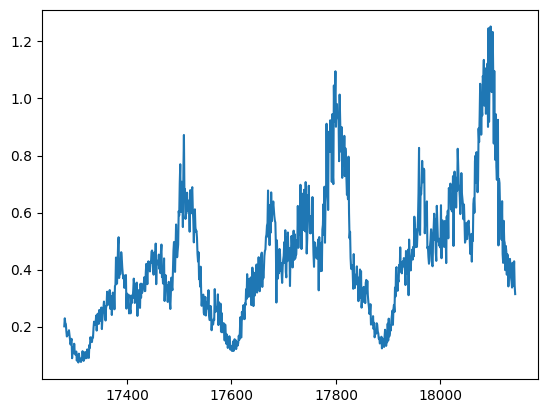

In [ ]:
plt.plot(water_house.iloc[-864:]['water_consumption'])

In [ ]:
water_house['id_house'].nunique()

2215

In [ ]:
water_house['id_house'].count()

np.int64(40188960)

In [ ]:
water_house[water_house['time_5min'].between('2025-09-01','2025-10-31')]['id_house'].count()

np.int64(38277415)

In [ ]:
water_house[water_house['time_5min'].between('2025-09-01','2025-10-31')]['time_5min'].min()

Timestamp('2025-09-01 00:00:00')

In [ ]:
# сохраняю сен-окт
water_house[water_house['time_5min'].between('2025-09-01','2025-10-31')].to_csv('/content/drive/MyDrive/LDT_2025/water_consump_0910.csv', index=False)

In [ ]:
water_house = pd.read_csv('/content/drive/MyDrive/LDT_2025/water_consump_0910.csv')

In [ ]:
water_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38277415 entries, 0 to 38277414
Data columns (total 3 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id_house           int64  
 1   time_5min          object 
 2   water_consumption  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 876.1+ MB


In [ ]:
water_house['time_5min'] = pd.to_datetime(water_house['time_5min'] )

In [ ]:
water_20250901 = water_house[(water_house['time_5min'].dt.month==9)&(water_house['time_5min'].dt.day==1)&(water_house['id_house']==0)]

In [ ]:
water_20250901

,id_house,time_5min,water_consumption
0,0,2025-09-01 00:00:00,0.230692
1,0,2025-09-01 00:05:00,0.226168
2,0,2025-09-01 00:10:00,0.187522
3,0,2025-09-01 00:15:00,0.164167
4,0,2025-09-01 00:20:00,0.204788
...,...,...,...
283,0,2025-09-01 23:35:00,0.252045
284,0,2025-09-01 23:40:00,0.209237
285,0,2025-09-01 23:45:00,0.178221
286,0,2025-09-01 23:50:00,0.203160


In [ ]:
288/24/12

1.0

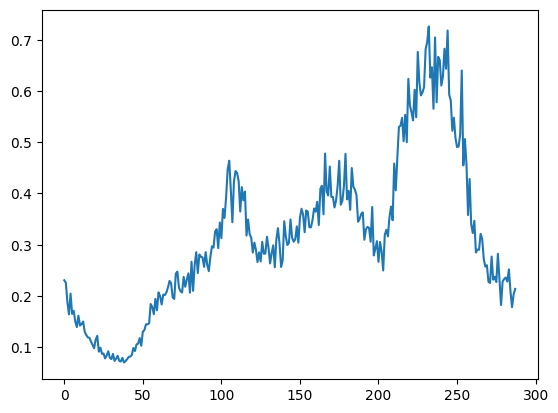

In [ ]:
plt.plot(water_20250901['water_consumption'].values)

## Генерация ряда по горячей воде  
Т.к. отклонение считается 10%, то чтобы укладывалось в 3 сигма, сигма должна быть НЕ больше 3.3%

Сначала генерим равномерное распределение из [0; 0.033], затем генерим нормальное с сигмой по полученному распр-ю, полученное умножаем на ряд - это шум, складываем шум я с рядом

In [ ]:
water_house = pd.DataFrame()
for i in range(2215):
  base_consumption = np.random.uniform(low=-0.1, high=0.1)
  noise_level = np.random.uniform(low=0.07, high=0.12)
  a = generate_water_(i, noise_level, base_consumption, days=63)
  water_house = pd.concat([water_house, a])


In [ ]:
water_house.shape

(38277415, 3)

In [ ]:
unif = np.random.uniform(low=0.01, high=0.0333,size=38277415)

In [ ]:
unif.shape

(38277415,)

In [ ]:
unif[:10]

array([0.03065801, 0.03051895, 0.0169946 , 0.0111249 , 0.02042539,
       0.02447778, 0.01207121, 0.01272135, 0.01307427, 0.03164618])

In [ ]:
norm = np.random.normal(loc=0.0, scale=unif, size=38277415)

In [ ]:
norm.shape

(38277415,)

In [ ]:
norm[:10]

array([-0.00061482, -0.01180981,  0.02314152,  0.00030101,  0.01087187,
       -0.00560175,  0.00358537,  0.00732499,  0.0086862 , -0.02193921])

In [ ]:
water_house['noise_hot'] = norm

In [ ]:
water_house['noise_hot'].mean()

np.float64(-4.9226688104970945e-06)

In [ ]:
water_house['water_hot'] = water_house['water_consumption']*water_house['noise_hot'] + water_house['water_consumption']

In [ ]:
water_house['water_consumption'] = water_house['water_consumption'].round(3)
water_house['water_hot'] = water_house['water_hot'].round(3)

In [ ]:
water_house.head()

,id_house,time_5min,water_consumption,noise_hot,water_hot
0,0,2025-09-01 00:00:00,0.231,-0.000615,0.231
1,0,2025-09-01 00:05:00,0.226,-0.011810,0.223
2,0,2025-09-01 00:10:00,0.188,0.023142,0.192
3,0,2025-09-01 00:15:00,0.164,0.000301,0.164
4,0,2025-09-01 00:20:00,0.205,0.010872,0.207


In [ ]:
water_house['change'] = abs(water_house['water_consumption']-water_house['water_hot'])/water_house['water_consumption']

In [ ]:
water_house.head()

,id_house,time_5min,water_consumption,noise_hot,water_hot,change
0,0,2025-09-01 00:00:00,0.231,-0.000615,0.231,0.000000
1,0,2025-09-01 00:05:00,0.226,-0.011810,0.223,0.013274
2,0,2025-09-01 00:10:00,0.188,0.023142,0.192,0.021277
3,0,2025-09-01 00:15:00,0.164,0.000301,0.164,0.000000
4,0,2025-09-01 00:20:00,0.205,0.010872,0.207,0.009756


In [ ]:
water_house[(water_house['water_consumption']>0.01)&(water_house['change']>=0.1)]['id_house'].count()

np.int64(12608)

In [ ]:
water_house[(water_house['water_consumption']>0.015)&(water_house['change']>=0.1)]

,id_house,time_5min,water_consumption,noise_hot,water_hot,change
1014,0,2025-09-04 12:30:00,0.287,0.120469,0.322,0.121951
3204,0,2025-09-12 03:00:00,0.081,-0.102559,0.072,0.111111
4086,0,2025-09-15 04:30:00,0.160,0.131322,0.181,0.131250
5210,0,2025-09-19 02:10:00,0.097,0.098365,0.107,0.103093
7427,0,2025-09-26 18:55:00,0.515,0.102630,0.568,0.102913
...,...,...,...,...,...,...
38254649,2213,2025-10-11 23:00:00,0.133,-0.111373,0.118,0.112782
38265786,2214,2025-09-20 15:00:00,0.560,0.118817,0.627,0.119643
38265817,2214,2025-09-20 17:35:00,0.637,0.103493,0.703,0.103611
38270295,2214,2025-10-06 06:45:00,0.236,-0.108907,0.210,0.110169


Норм, отклонения возможны

In [ ]:
2215*24*12

637920

Сохранение

In [ ]:
water_house[water_house['time_5min'].between('2025-09-01','2025-10-31')]['id_house'].count()

np.int64(38277415)

In [ ]:
# сохраняю сен-окт
water_house[water_house['time_5min'].between('2025-09-01','2025-10-31')].drop(columns='change').to_csv('/content/drive/MyDrive/LDT_2025/water_consump_hot.csv', index=False)

### Первый сбой-аномалия: расхождение между ХВС и ГВС растет

In [ ]:
water_house = pd.read_csv('/content/drive/MyDrive/LDT_2025/water_consump_hot.csv')

In [ ]:
water_house['time_5min'] = pd.to_datetime(water_house['time_5min'] )

In [ ]:
water_house['time_5min'].max()

Timestamp('2025-10-31 00:00:00')

In [ ]:
water_house['change'] = abs(water_house['water_consumption']-water_house['water_hot'])/water_house['water_consumption']

In [ ]:
water_house[(water_house['water_consumption']>0.01)&(water_house['change']>=0.1)]['id_house'].count()

np.int64(12608)

In [ ]:
wtr_2 = water_house[(water_house['water_consumption']>0.01)&(water_house['change']>0.13)]

In [ ]:
wtr_2[(wtr_2['time_5min'].dt.month==9)&(wtr_2['time_5min'].dt.day.isin([28,29]))]

,id_house,time_5min,water_consumption,noise_hot,water_hot,change
3274279,189,2025-09-29 08:50:00,0.358,0.135000,0.406,0.134078
3377806,195,2025-09-28 19:35:00,0.919,0.150807,1.058,0.151251
10826195,626,2025-09-29 18:45:00,0.547,0.137063,0.622,0.137112
12018109,695,2025-09-28 03:10:00,0.021,-0.100208,0.018,0.142857
14316865,828,2025-09-29 11:05:00,0.284,-0.141534,0.244,0.140845
15802632,914,2025-09-28 01:50:00,0.011,0.104816,0.013,0.181818
17029650,985,2025-09-28 07:25:00,0.301,0.146174,0.345,0.146179
21626335,1251,2025-09-28 02:20:00,0.053,-0.121445,0.046,0.132075
22265712,1288,2025-09-28 00:40:00,0.122,0.143327,0.140,0.147541
22507640,1302,2025-09-28 00:10:00,0.092,0.123568,0.104,0.130435


Устраивает 828 дом

In [ ]:
wtr_828 = water_house[(water_house['id_house']==828)]

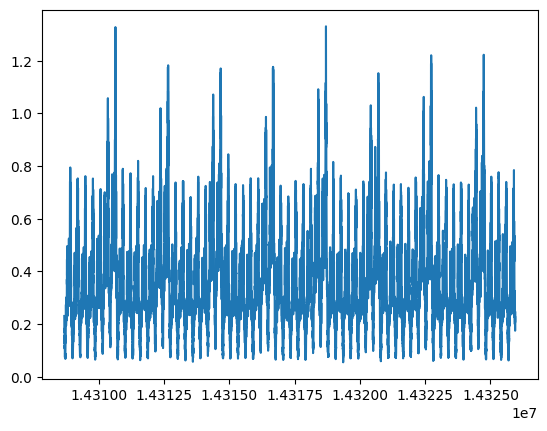

In [ ]:
plt.plot(wtr_828['water_consumption'])

28-30 сен

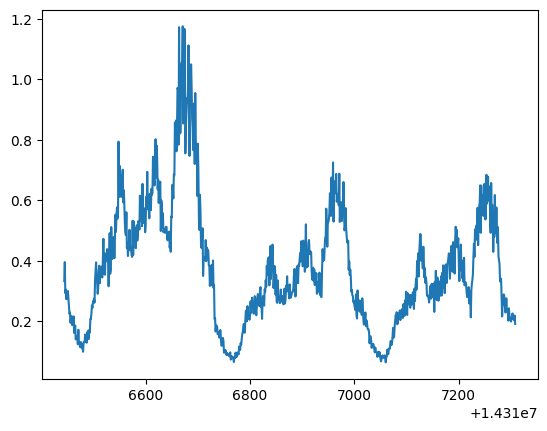

In [ ]:
plt.plot(wtr_828[wtr_828['time_5min'].between('2025-09-28 00:00:00', '2025-10-01 00:00:00')]['water_consumption'])

In [ ]:
3*12*24*0.01

8.64

In [ ]:
def add_linear_trend_to_column(df, timestamp_col, value_col, start_date, end_date, slope):
    """
    Добавляет линейный тренд к указанному временному интервалу

    Parameters:
    df: pd.DataFrame - DataFrame с данными
    timestamp_col: str - название столбца с временными метками
    value_col: str - название столбца с значениями
    start_date: str - начало тренда ('YYYY-MM-DD HH:MM:SS')
    end_date: str - конец тренда ('YYYY-MM-DD HH:MM:SS')
    slope: float - наклон тренда (изменение за единицу времени)
    """
    df = df.copy()

    # Преобразуем даты в timestamp
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)

    # Находим индексы строк в заданном интервале
    mask = (df[timestamp_col] >= start_ts) & (df[timestamp_col] <= end_ts)
    trend_indices = df[mask].index

    if len(trend_indices) == 0:
        print("В указанном интервале нет данных")
        return df

    # Вычисляем базовое значение для тренда
    base_value = df.loc[trend_indices[0], value_col]

    # Добавляем тренд в цикле
    for i, idx in enumerate(trend_indices):
        time_passed = i  # количество временных интервалов
        trend_increment = time_passed * slope
        df.loc[idx, value_col] += trend_increment

    return df

За новый период

In [ ]:
wtr_828_trend = add_linear_trend_to_column(
    df=wtr_828,
    timestamp_col='time_5min',
    value_col='water_consumption',
    start_date='2025-10-01 00:00:00',
    end_date='2025-10-07 00:00:00',
    slope=0.0005  # увеличение за каждый 5-минутный интервал
)

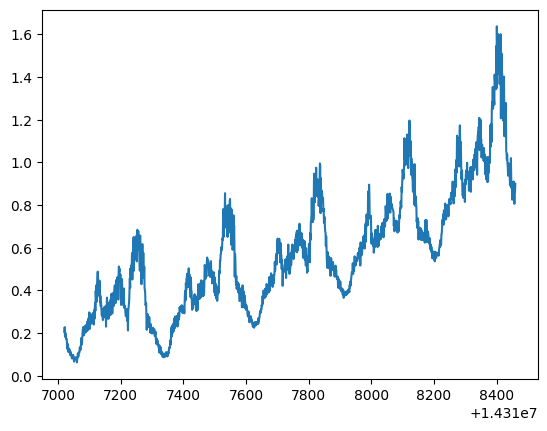

In [ ]:
plt.plot(wtr_828_trend[wtr_828_trend['time_5min'].between('2025-09-30 00:00:00', '2025-10-05 00:00:00')]['water_consumption'])

Прежний период

In [ ]:
wtr_828_trend = add_linear_trend_to_column(
    df=wtr_828,
    timestamp_col='time_5min',
    value_col='water_consumption',
    start_date='2025-09-28 00:00:00',
    end_date='2025-10-03 00:00:00',
    slope=0.001  # увеличение за каждый 5-минутный интервал
)

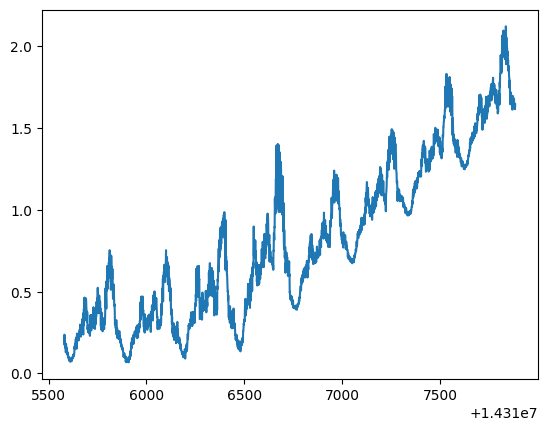

In [ ]:
plt.plot(wtr_828_trend[wtr_828_trend['time_5min'].between('2025-09-25 00:00:00', '2025-10-03 00:00:00')]['water_consumption'])

In [ ]:
wtr_828_trend2 = wtr_828_trend.drop(columns=['noise_hot'])
wtr_828_trend2['id_house'] = 3000

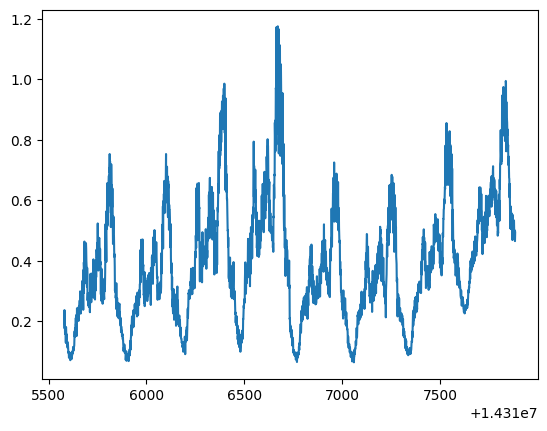

In [ ]:
plt.plot(wtr_828_trend2[wtr_828_trend2['time_5min'].between('2025-09-25 00:00:00', '2025-10-03 00:00:00')]['water_consumption'])

In [ ]:
wtr_828_trend.head()

,id_house,time_5min,water_consumption,noise_hot,water_hot
14308668,828,2025-09-01 00:00:00,0.230,0.015886,0.234
14308669,828,2025-09-01 00:05:00,0.179,0.006650,0.180
14308670,828,2025-09-01 00:10:00,0.189,-0.016790,0.186
14308671,828,2025-09-01 00:15:00,0.170,0.000244,0.170
14308672,828,2025-09-01 00:20:00,0.169,0.015314,0.171


In [ ]:
wtr_828_trend2.columns

Index(['id_house', 'time_5min', 'water_consumption', 'water_hot'], dtype='object')

In [ ]:
wtr_828_trend2[['id_house', 'time_5min','water_consumption', 'water_hot']].to_csv('/content/drive/MyDrive/LDT_2025/water_lintrend_3000_2.csv', index=False)

In [ ]:
wtr_3k = pd.read_csv('/content/drive/MyDrive/LDT_2025/water_lintrend_3000.csv')

In [ ]:
wtr_3k

,id_house,time_5min,water_consumption,water_hot
0,3000,2025-09-01 00:00:00,0.230,0.234
1,3000,2025-09-01 00:05:00,0.179,0.180
2,3000,2025-09-01 00:10:00,0.189,0.186
3,3000,2025-09-01 00:15:00,0.170,0.170
4,3000,2025-09-01 00:20:00,0.169,0.171
...,...,...,...,...
17276,3000,2025-10-30 23:40:00,0.229,0.225
17277,3000,2025-10-30 23:45:00,0.227,0.230
17278,3000,2025-10-30 23:50:00,0.174,0.171
17279,3000,2025-10-30 23:55:00,0.247,0.240


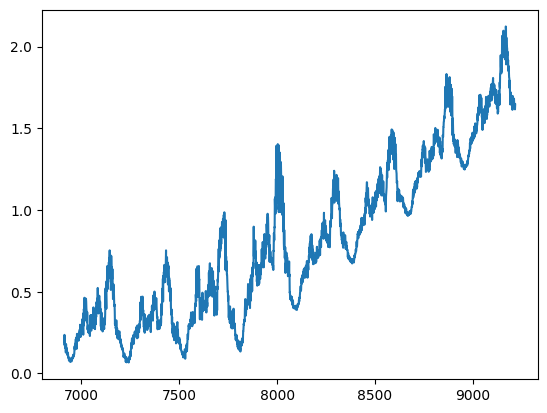

In [ ]:
plt.plot(wtr_3k[wtr_3k['time_5min'].between('2025-09-25 00:00:00', '2025-10-03 00:00:00')]['water_consumption'])

## Второй сбой аномалия: иногда резкие всплески по холодной воде

In [ ]:
wtr_189 = water_house[(water_house['id_house']==189)]

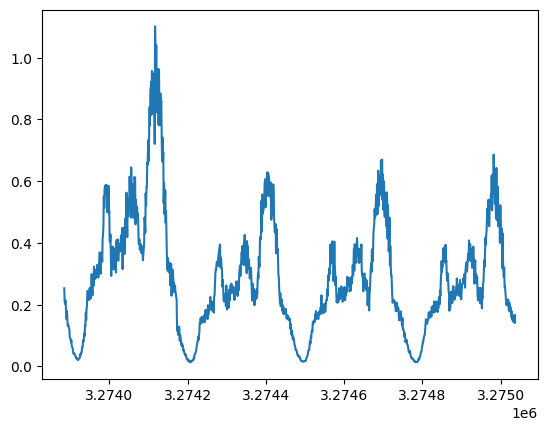

In [ ]:
plt.plot(wtr_189[wtr_189['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
def add_jump_to_column(df, timestamp_col, value_col, start_date, end_date):
    """
    Добавляет линейный тренд к указанному временному интервалу

    Parameters:
    df: pd.DataFrame - DataFrame с данными
    timestamp_col: str - название столбца с временными метками
    value_col: str - название столбца с значениями
    start_date: str - начало тренда ('YYYY-MM-DD HH:MM:SS')
    end_date: str - конец тренда ('YYYY-MM-DD HH:MM:SS')
    slope: float - наклон тренда (изменение за единицу времени)
    """
    df = df.copy()

    # Преобразуем даты в timestamp
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)

    date_minus7d = start_ts - pd.DateOffset(days=7)
    mask_hist = (df[timestamp_col] >= date_minus7d) & (df[timestamp_col] < start_ts)
    value_mean = df[mask_hist][value_col].mean()
    print(value_mean)

    # Находим индексы строк в заданном интервале
    mask = (df[timestamp_col] >= start_ts) & (df[timestamp_col] <= end_ts)
    jump_indices = df[mask].index

    if len(jump_indices) == 0:
        print("В указанном интервале нет данных")
        return df

    # Добавляем всплески в x% случаев
    for i, idx in enumerate(jump_indices):
        if np.random.random() <= 0.05:
          df.loc[idx, value_col] = max(value_mean * np.random.uniform(low=1.5, high=2), df.loc[idx, value_col])

    return df

In [ ]:
wtr_189_jump = add_jump_to_column(
    df=wtr_189,
    timestamp_col='time_5min',
    value_col='water_consumption',
    start_date='2025-09-28 00:00:00',
    end_date='2025-10-03 00:00:00'
)

0.28851140873015874


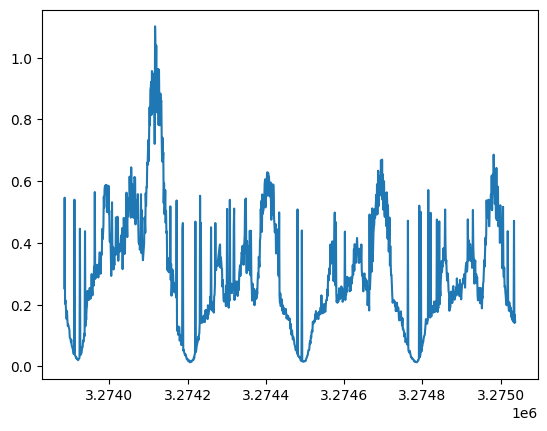

In [ ]:
plt.plot(wtr_189_jump[wtr_189_jump['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
wtr_189_jump2 = wtr_189_jump.drop(columns=['noise_hot'])
wtr_189_jump2['id_house'] = 3001

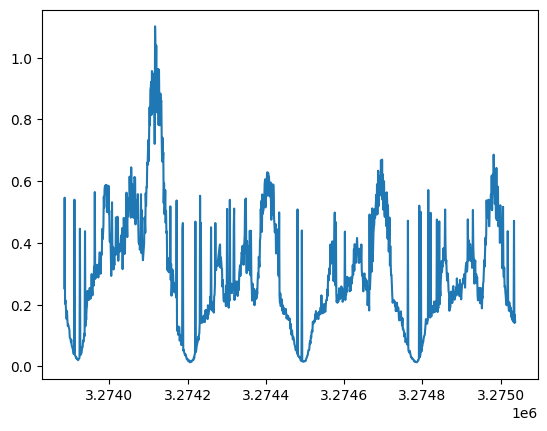

In [ ]:
plt.plot(wtr_189_jump2[wtr_189_jump2['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
# сохранение
wtr_189_jump2[['id_house', 'time_5min','water_consumption', 'water_hot']].to_csv('/content/drive/MyDrive/LDT_2025/wtr_jump_3001.csv', index=False)

## Третий сбой-аномалия: иногда пропущенные значения

In [ ]:
wtr_1662 = water_house[(water_house['id_house']==1662)]

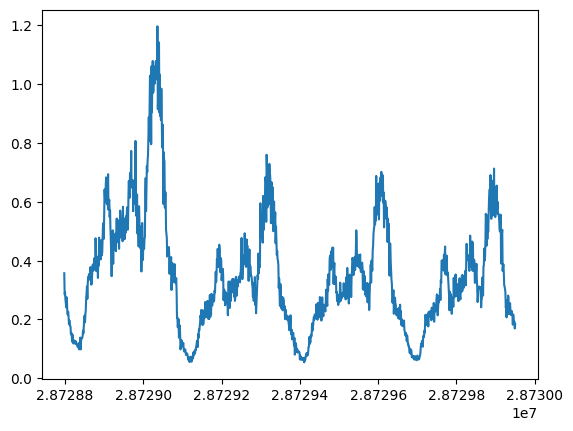

In [ ]:
plt.plot(wtr_1662[wtr_1662['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
def add_blank_to_column(df, timestamp_col, value_col, start_date, end_date):
    """
    Добавляет линейный тренд к указанному временному интервалу

    Parameters:
    df: pd.DataFrame - DataFrame с данными
    timestamp_col: str - название столбца с временными метками
    value_col: str - название столбца с значениями
    start_date: str - начало тренда ('YYYY-MM-DD HH:MM:SS')
    end_date: str - конец тренда ('YYYY-MM-DD HH:MM:SS')
    slope: float - наклон тренда (изменение за единицу времени)
    """
    df = df.copy()

    # Преобразуем даты в timestamp
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)

    # Находим индексы строк в заданном интервале
    mask = (df[timestamp_col] >= start_ts) & (df[timestamp_col] <= end_ts)
    jump_indices = df[mask].index

    if len(jump_indices) == 0:
        print("В указанном интервале нет данных")
        return df

    # Добавляем None x% случаев
    for i, idx in enumerate(jump_indices):
        if np.random.random() <= 0.2:
          df.loc[idx, value_col] = None

    return df

In [ ]:
wtr_1662_blank = add_blank_to_column(
    df=wtr_1662,
    timestamp_col='time_5min',
    value_col='water_consumption',
    start_date='2025-09-28 00:00:00',
    end_date='2025-10-03 00:00:00'
)

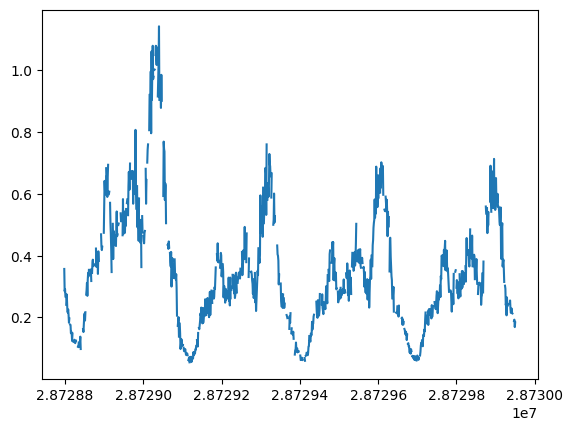

In [ ]:
plt.plot(wtr_1662_blank[wtr_1662_blank['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
wtr_1662_blank2 = wtr_1662_blank.drop(columns=['noise_hot'])
wtr_1662_blank2['id_house'] = 3002

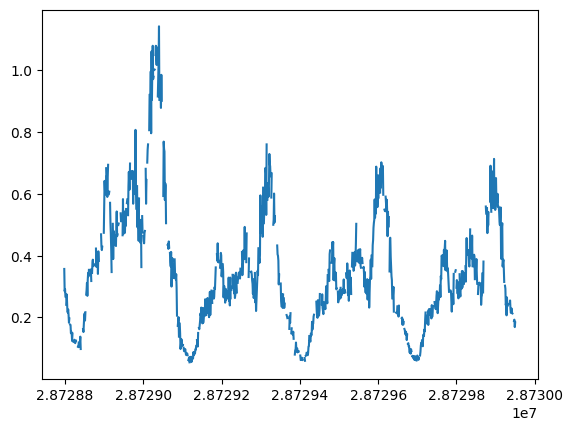

In [ ]:
plt.plot(wtr_1662_blank2[wtr_1662_blank2['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
# сохранение
wtr_1662_blank2[['id_house', 'time_5min','water_consumption', 'water_hot']].to_csv('/content/drive/MyDrive/LDT_2025/wtr_blank_3002.csv', index=False)

## Четвертый сбой-аномалия: константа с какого-то момента

In [ ]:
wtr_1513 = water_house[(water_house['id_house']==1513)]

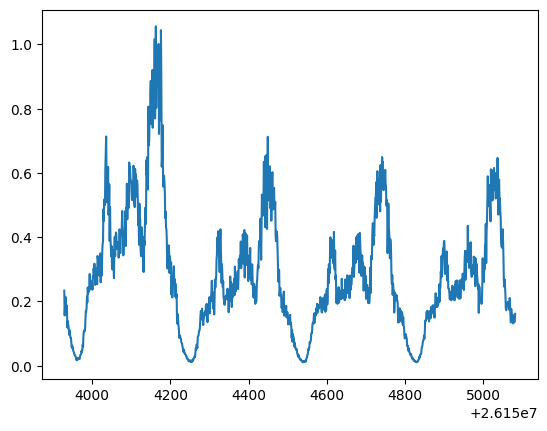

In [ ]:
plt.plot(wtr_1513[wtr_1513['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
def add_const_to_column(df, timestamp_col, value_col, start_date, end_date):
    """
    Добавляет линейный тренд к указанному временному интервалу

    Parameters:
    df: pd.DataFrame - DataFrame с данными
    timestamp_col: str - название столбца с временными метками
    value_col: str - название столбца с значениями
    start_date: str - начало тренда ('YYYY-MM-DD HH:MM:SS')
    end_date: str - конец тренда ('YYYY-MM-DD HH:MM:SS')
    slope: float - наклон тренда (изменение за единицу времени)
    """
    df = df.copy()

    # Преобразуем даты в timestamp
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)

    # Находим индексы строк в заданном интервале
    mask = (df[timestamp_col] >= start_ts) & (df[timestamp_col] <= end_ts)
    jump_indices = df[mask].index

    if len(jump_indices) == 0:
        print("В указанном интервале нет данных")
        return df

    date_minus7d = start_ts - pd.DateOffset(days=7)
    mask_hist = (df[timestamp_col] >= date_minus7d) & (df[timestamp_col] < start_ts)
    value_mean = df[mask_hist][value_col].mean()
    print(value_mean)

    # Добавляем константу в x% случаев
    f=0
    for i, idx in enumerate(jump_indices):
        if f==1:
          if np.random.random() >=0.1:
            df.loc[idx, value_col] = value_mean + np.random.normal(0, 0.05 * value_mean)*value_mean
          else:
            df.loc[idx, value_col] = None
        elif abs(value_mean-df.loc[idx, value_col])/value_mean <=0.05:
          f=1
          df.loc[idx, value_col] = value_mean + np.random.normal(0, 0.05 * value_mean)*value_mean

    return df

In [ ]:
wtr_1513_const = add_const_to_column(
    df=wtr_1513,
    timestamp_col='time_5min',
    value_col='water_consumption',
    start_date='2025-09-28 00:00:00',
    end_date='2025-10-03 00:00:00'
)

0.28748363095238094


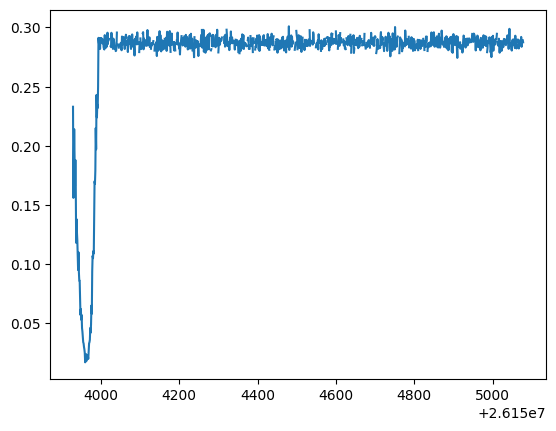

In [ ]:
plt.plot(wtr_1513_const[wtr_1513_const['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
wtr_1513_const2 = wtr_1513_const.drop(columns=['noise_hot'])
wtr_1513_const2['id_house'] = 3003

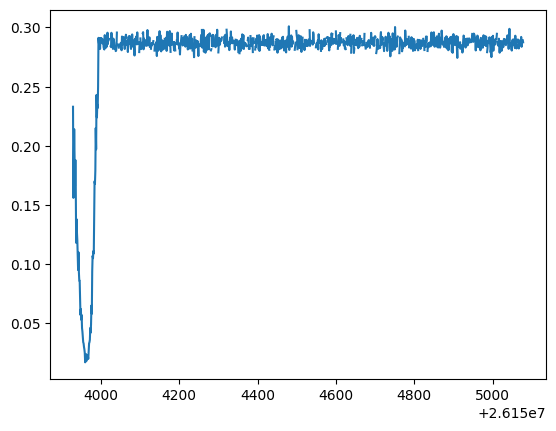

In [ ]:
plt.plot(wtr_1513_const2[wtr_1513_const2['time_5min'].between('2025-09-28 00:00:00', '2025-10-02 00:00:00')]['water_consumption'])

In [ ]:
# сохранение
wtr_1513_const2[['id_house', 'time_5min','water_consumption', 'water_hot']].to_csv('/content/drive/MyDrive/LDT_2025/wtr_const_3003.csv', index=False)

In [ ]:
12*24*0.1

28.8

In [ ]:
24*5

120

Сбор прогноза из разных файлов

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import os

In [ ]:
def merge_forecasts(output_dir, final_output_file):
    """Объединение всех прогнозов в один файл"""
    print("Объединение прогнозов...")

    all_forecasts = []

    # Ищем все файлы с прогнозами
    forecast_files = [f for f in os.listdir(output_dir) if f.endswith('_forecast.csv')]

    for file in tqdm(forecast_files, desc="Объединение файлов"):
        file_path = os.path.join(output_dir, file)
        try:
            forecast_df = pd.read_csv(file_path)
            all_forecasts.append(forecast_df)
        except Exception as e:
            print(f"Ошибка чтения файла {file}: {e}")

    if all_forecasts:
        # Объединяем все прогнозы
        final_forecast = pd.concat(all_forecasts, ignore_index=True)
        final_forecast.to_csv(final_output_file, index=False)

        print(f"Объединенный файл сохранен: {final_output_file}")
        print(f"Всего прогнозов: {len(final_forecast)}")
        print(f"Уникальных домов: {final_forecast['id_house'].nunique()}")

        return final_forecast
    else:
        print("Нет файлов для объединения")
        return None

In [ ]:
merge_forecasts('/content/drive/MyDrive/LDT_2025/water_forecast', '/content/drive/MyDrive/LDT_2025/water_forecast_all.csv')

Объединение прогнозов...


Объединение файлов: 100%|██████████| 2215/2215 [02:08<00:00, 17.24it/s]


Объединенный файл сохранен: /content/drive/MyDrive/LDT_2025/water_forecast_all.csv
Всего прогнозов: 11482560
Уникальных домов: 2215


,id_house,ds,yhat,yhat_lower,yhat_upper
0,1215,2025-10-02 00:00:00,0.139461,0.098874,0.176091
1,1215,2025-10-02 00:05:00,0.134957,0.090531,0.173404
2,1215,2025-10-02 00:10:00,0.129181,0.088335,0.168834
3,1215,2025-10-02 00:15:00,0.122391,0.081424,0.158044
4,1215,2025-10-02 00:20:00,0.115057,0.076031,0.156131
...,...,...,...,...,...
11482555,214,2025-10-19 23:35:00,0.290535,0.250434,0.337439
11482556,214,2025-10-19 23:40:00,0.281835,0.236120,0.326859
11482557,214,2025-10-19 23:45:00,0.274053,0.228697,0.319696
11482558,214,2025-10-19 23:50:00,0.266941,0.226921,0.310625
